<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/Methodology/Model_30_no_freq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyLDAvis

In [2]:
!pip3 install pickle5

     |████████████████████████████████| 133kB 3.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219281 sha256=947b72fd78787f37b565d0fa003384ba65f654a69910a8fde20fd7121c84a53d
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [3]:
import os
import numpy as np
import pandas as pd
import pickle5 as pickle
from pprint import pprint

## Dataset

Below is our dataset:

In [4]:
with open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/df_all_final.pkl", "rb") as fh:
  df = pickle.load(fh)

In [5]:
df

,JO,AU,TI,PY,DI,urls,filename,methodology
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room n...,2019.0,10.1108/IJCHM-01-2019-0061,https://www.emerald.com/insight/content/doi/10...,IJCHM_0.txt,Methodology\nThe design is qualitative and exp...
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation...,2019.0,10.1108/IJCHM-01-2019-0090,https://www.emerald.com/insight/content/doi/10...,IJCHM_1.txt,Data\nThere are no official statistics on the ...
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online rati...,2019.0,10.1108/IJCHM-10-2018-0835,https://www.emerald.com/insight/content/doi/10...,IJCHM_2.txt,3. Research method\nWe searched the empirical ...
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimu...,2019.0,10.1108/IJCHM-10-2018-0827,https://www.emerald.com/insight/content/doi/10...,IJCHM_3.txt,Methods\nParticipants\nEmployees from operatio...
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restauran...,2019.0,10.1108/IJCHM-03-2018-0235,https://www.emerald.com/insight/content/doi/10...,IJCHM_4.txt,Method\nDesign\nParticipants made dining decis...
...,...,...,...,...,...,...,...,...
3264,JHTR,"Kim, W; Ok, C",CUSTOMER ORIENTATION OF SERVICE EMPLOYEES AND ...,2010.0,10.1177/1096348009344234,NaN,NaN,\nMETHOD\nMeasures\nSignificant discrepant res...
3265,JHTR,"Gazzoli, G; Hancer, M; Park, Y",THE ROLE AND EFFECT OF JOB SATISFACTION AND EM...,2010.0,10.1177/1096348009344235,NaN,NaN,\nMETHOD\nSample and Data Collection\nBecause ...
3266,JHTR,"Young, CA; Corsun, DL","BURNED! THE IMPACT OF WORK ASPECTS, INJURY, AN...",2010.0,10.1177/1096348009349816,NaN,NaN,\nMETHOD\nData Collection\nManagement from 13 ...
3267,JHTR,"Kim, DY; Wen, L; Doh, K",DOES CULTURAL DIFFERENCE AFFECT CUSTOMER'S RES...,2010.0,10.1177/1096348009349817,NaN,NaN,\nMETHOD\nSample\nAn experimental design was e...


The dataset includes **3269** articles from **5 journals**.

In [6]:
df.dropna(subset=["methodology"], inplace=True)

In [7]:
df

,JO,AU,TI,PY,DI,urls,filename,methodology
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room n...,2019.0,10.1108/IJCHM-01-2019-0061,https://www.emerald.com/insight/content/doi/10...,IJCHM_0.txt,Methodology\nThe design is qualitative and exp...
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation...,2019.0,10.1108/IJCHM-01-2019-0090,https://www.emerald.com/insight/content/doi/10...,IJCHM_1.txt,Data\nThere are no official statistics on the ...
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online rati...,2019.0,10.1108/IJCHM-10-2018-0835,https://www.emerald.com/insight/content/doi/10...,IJCHM_2.txt,3. Research method\nWe searched the empirical ...
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimu...,2019.0,10.1108/IJCHM-10-2018-0827,https://www.emerald.com/insight/content/doi/10...,IJCHM_3.txt,Methods\nParticipants\nEmployees from operatio...
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restauran...,2019.0,10.1108/IJCHM-03-2018-0235,https://www.emerald.com/insight/content/doi/10...,IJCHM_4.txt,Method\nDesign\nParticipants made dining decis...
...,...,...,...,...,...,...,...,...
3264,JHTR,"Kim, W; Ok, C",CUSTOMER ORIENTATION OF SERVICE EMPLOYEES AND ...,2010.0,10.1177/1096348009344234,NaN,NaN,\nMETHOD\nMeasures\nSignificant discrepant res...
3265,JHTR,"Gazzoli, G; Hancer, M; Park, Y",THE ROLE AND EFFECT OF JOB SATISFACTION AND EM...,2010.0,10.1177/1096348009344235,NaN,NaN,\nMETHOD\nSample and Data Collection\nBecause ...
3266,JHTR,"Young, CA; Corsun, DL","BURNED! THE IMPACT OF WORK ASPECTS, INJURY, AN...",2010.0,10.1177/1096348009349816,NaN,NaN,\nMETHOD\nData Collection\nManagement from 13 ...
3267,JHTR,"Kim, DY; Wen, L; Doh, K",DOES CULTURAL DIFFERENCE AFFECT CUSTOMER'S RES...,2010.0,10.1177/1096348009349817,NaN,NaN,\nMETHOD\nSample\nAn experimental design was e...


In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df["PY"].fillna(2010, inplace=True)

In [10]:
df["PY"] = df.PY.astype("int")

In [11]:
df.isnull().sum()

JO              0
AU              0
TI              0
PY              0
DI              1
urls           83
filename       84
methodology     0
dtype: int64

In [12]:
df.drop_duplicates(subset="TI")

,JO,AU,TI,PY,DI,urls,filename,methodology
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room n...,2019,10.1108/IJCHM-01-2019-0061,https://www.emerald.com/insight/content/doi/10...,IJCHM_0.txt,Methodology\nThe design is qualitative and exp...
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation...,2019,10.1108/IJCHM-01-2019-0090,https://www.emerald.com/insight/content/doi/10...,IJCHM_1.txt,Data\nThere are no official statistics on the ...
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online rati...,2019,10.1108/IJCHM-10-2018-0835,https://www.emerald.com/insight/content/doi/10...,IJCHM_2.txt,3. Research method\nWe searched the empirical ...
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimu...,2019,10.1108/IJCHM-10-2018-0827,https://www.emerald.com/insight/content/doi/10...,IJCHM_3.txt,Methods\nParticipants\nEmployees from operatio...
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restauran...,2019,10.1108/IJCHM-03-2018-0235,https://www.emerald.com/insight/content/doi/10...,IJCHM_4.txt,Method\nDesign\nParticipants made dining decis...
...,...,...,...,...,...,...,...,...
3071,JHTR,"Kim, W; Ok, C",CUSTOMER ORIENTATION OF SERVICE EMPLOYEES AND ...,2010,10.1177/1096348009344234,NaN,NaN,\nMETHOD\nMeasures\nSignificant discrepant res...
3072,JHTR,"Gazzoli, G; Hancer, M; Park, Y",THE ROLE AND EFFECT OF JOB SATISFACTION AND EM...,2010,10.1177/1096348009344235,NaN,NaN,\nMETHOD\nSample and Data Collection\nBecause ...
3073,JHTR,"Young, CA; Corsun, DL","BURNED! THE IMPACT OF WORK ASPECTS, INJURY, AN...",2010,10.1177/1096348009349816,NaN,NaN,\nMETHOD\nData Collection\nManagement from 13 ...
3074,JHTR,"Kim, DY; Wen, L; Doh, K",DOES CULTURAL DIFFERENCE AFFECT CUSTOMER'S RES...,2010,10.1177/1096348009349817,NaN,NaN,\nMETHOD\nSample\nAn experimental design was e...


In [13]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

In [14]:
id2word = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/id2word_no_freq.pkl", "rb"))
corpus = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/corpus_no_freq.pkl", "rb"))
data_ready = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/data_ready_no_freq.pkl", "rb"))

In [15]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=5, no_above=0.5)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 6020


In [16]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### Build the Topic Model

In [17]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-05-22 06:12:09--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  14.8MB/s    in 1.0s    

2021-05-22 06:12:10 (14.8 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [18]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [19]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'  

In [20]:
num_topics=30

In [21]:
alpha=5/num_topics

In [22]:
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=2000, alpha=alpha)

Below you can find the 30 topics formed by the model. For each topic there are 10 terms and their relative weights next to it in descending order. 

In [23]:
# Show Topics
# pprint(ldamallet.show_topics(formatted=False, num_topics=num_topics))

# Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

In [24]:
# pickle.dump(ldamallet, open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/model_30_no_freq_1.pkl", "wb"))

In [25]:
ldamallet = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/model_30_no_freq_1.pkl", "rb"))

In [26]:
# tm_results = ldamallet[corpus]

In [27]:
# pickle.dump(tm_results, open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/tm_results_30_no_freq_1.pkl", "wb"))

In [28]:
tm_results = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/tm_results_30_no_freq_1.pkl", "rb"))

In [29]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [30]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=10)] for n in range(0, ldamallet.num_topics)]

Below is the Topic-Term matrix shows 10 terms that forms each topic.   

In [31]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 11)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,participant,tourism,service,effect,attribute,employee,firm,wine,tourist,cost,online,restaurant,article,cent,environmental,review,brand,estimate,event,case,service,room,interview,manager,company,factor,construct,casino,work,market
Term2,scenario,network,customer,significant,importance,work,asset,price,tourism,activity,participant,food,journal,family,green,rating,customer,input,festival,approach,customer,price,code,group,performance,construct,measurement,game,employee,rate
Term3,condition,social,restaurant,support,criterion,supervisor,size,consumer,destination,food,experience,menu,author,female,practice,online,luxury,efficiency,convention,process,quality,guest,researcher,management,innovation,measurement,validity,resort,hospitality,period
Term4,subject,business,failure,regression,cluster,manager,control,purchase,country,room,travel,dining,paper,child,sustainability,website,loyalty,output,exhibition,stage,experience,rate,participant,member,business,variance,researcher,gaming,industry,return
Term5,experiment,local,server,hypothesis,performance,performance,effect,discount,travel,water,perceive,type,tourism,gender,environment,feature,consumer,function,creation,design,satisfaction,property,qualitative,industry,service,reliability,section,player,career,event
Term6,design,resource,recovery,difference,important,team,performance,choice,visitor,system,stay,experience,hospitality,male,indicator,word,visit,demand,post,context,emotion,host,experience,training,manager,dimension,participant,represent,participant,performance
Term7,manipulation,community,behavior,relationship,factor,customer,financial,product,international,unit,demographic,korean,identify,group,concern,positive,reward,equation,visitor,researcher,guest,stay,theme,percent,firm,assess,pilot,play,student,average
Term8,manipulate,stakeholder,wait,interaction,identify,service,market,winery,city,order,adapt,service,keyword,woman,company,negative,image,regression,message,source,feel,airbnb,identify,director,employee,correlation,reliability,daily,feel,change
Term9,group,activity,scenario,satisfaction,score,range,ratio,group,local,group,measurement,meal,search,average,sustainable,customer,select,coefficient,exhibitor,system,dimension,average,process,position,customer,common,complete,property,satisfaction,segment
Term10,perceive,small,check,condition,weight,behavior,restaurant,quality,group,hour,intention,consumer,review,report,guest,term,perceive,revenue,community,understand,positive,location,category,work,market,validity,adopt,offer,organization,exhibit


In [32]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [33]:
topics_df

,Terms per Topic
Topic 1,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive"
Topic 2,"tourism, network, social, business, local, resource, community, stakeholder, activity, small"
Topic 3,"service, customer, restaurant, failure, server, recovery, behavior, wait, scenario, check"
Topic 4,"effect, significant, support, regression, hypothesis, difference, relationship, interaction, satisfaction, condition"
Topic 5,"attribute, importance, criterion, cluster, performance, important, factor, identify, score, weight"
Topic 6,"employee, work, supervisor, manager, performance, team, customer, service, range, behavior"
Topic 7,"firm, asset, size, control, effect, performance, financial, market, ratio, restaurant"
Topic 8,"wine, price, consumer, purchase, discount, choice, product, winery, group, quality"
Topic 9,"tourist, tourism, destination, country, travel, visitor, international, city, local, group"
Topic 10,"cost, activity, food, room, water, system, unit, order, group, hour"


In [34]:
!pip install docx2txt

  Created wheel for docx2txt: filename=docx2txt-0.8-cp37-none-any.whl size=3963 sha256=19fad0e3e41c2c3b6f551cac902438c33b1282a7ee0a389b9b976c3461c0f359
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
Successfully built docx2txt


In [35]:
import docx2txt
topics = docx2txt.process("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/Topics.docx")
print(topics)

Topic 1: Scenario-Based Experimental Design

Topic 2: Network Analysis

Topic 3: Service Management

Topic 4: Hypothesis Testing

Topic 5: Cluster Performance

Topic 6: Employee Behavior

Topic 7: Firm Performance

Topic 8: Wine Marketing

Topic 9: Destination 

Topic 10: Cost Management

Topic 11: Online Measurements

Topic 12: Restaurant Management 

Topic 13: Article Reviews

Topic 14: Demographics (Scale/Questionnaire)

Topic 15: Sustainability 

Topic 16: Online Textual Analysis

Topic 17: Brand Management

Topic 18: Regression Analysis

Topic 19: Event Management

Topic 20: Case Studies

Topic 21: Service Quality 

Topic 22: Room Rate

Topic 23: Interviews/Codes

Topic 24: Managers

Topic 25: Innovation Performance

Topic 26: Factor Analysis

Topic 27: Construct Validity

Topic 28: Casino

Topic 29: Hospitality

Topic 30: Market Rate


In [36]:
type(topics)

str

In [37]:
import re
topic_list = re.split(r"Topic \d{1,2}:", topics)
topic_list

['',
 ' Scenario-Based Experimental Design\n\n',
 ' Network Analysis\n\n',
 ' Service Management\n\n',
 ' Hypothesis Testing\n\n',
 ' Cluster Performance\n\n',
 ' Employee Behavior\n\n',
 ' Firm Performance\n\n',
 ' Wine Marketing\n\n',
 ' Destination \n\n',
 ' Cost Management\n\n',
 ' Online Measurements\n\n',
 ' Restaurant Management \n\n',
 ' Article Reviews\n\n',
 ' Demographics (Scale/Questionnaire)\n\n',
 ' Sustainability \n\n',
 ' Online Textual Analysis\n\n',
 ' Brand Management\n\n',
 ' Regression Analysis\n\n',
 ' Event Management\n\n',
 ' Case Studies\n\n',
 ' Service Quality \n\n',
 ' Room Rate\n\n',
 ' Interviews/Codes\n\n',
 ' Managers\n\n',
 ' Innovation Performance\n\n',
 ' Factor Analysis\n\n',
 ' Construct Validity\n\n',
 ' Casino\n\n',
 ' Hospitality\n\n',
 ' Market Rate']

In [38]:
topic_list= topic_list[1:]

In [39]:
len(topic_list)

30

In [40]:
topic_list = [t.strip() for t in topic_list]
topic_list

['Scenario-Based Experimental Design',
 'Network Analysis',
 'Service Management',
 'Hypothesis Testing',
 'Cluster Performance',
 'Employee Behavior',
 'Firm Performance',
 'Wine Marketing',
 'Destination',
 'Cost Management',
 'Online Measurements',
 'Restaurant Management',
 'Article Reviews',
 'Demographics (Scale/Questionnaire)',
 'Sustainability',
 'Online Textual Analysis',
 'Brand Management',
 'Regression Analysis',
 'Event Management',
 'Case Studies',
 'Service Quality',
 'Room Rate',
 'Interviews/Codes',
 'Managers',
 'Innovation Performance',
 'Factor Analysis',
 'Construct Validity',
 'Casino',
 'Hospitality',
 'Market Rate']

### WordClouds

In [41]:
from wordcloud import WordCloud

In [42]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [43]:
plt.rcParams['figure.figsize'] = [20, 15]

Below is the word clouds, one for each topic. The font sizes of words show their relative weights in the topic.

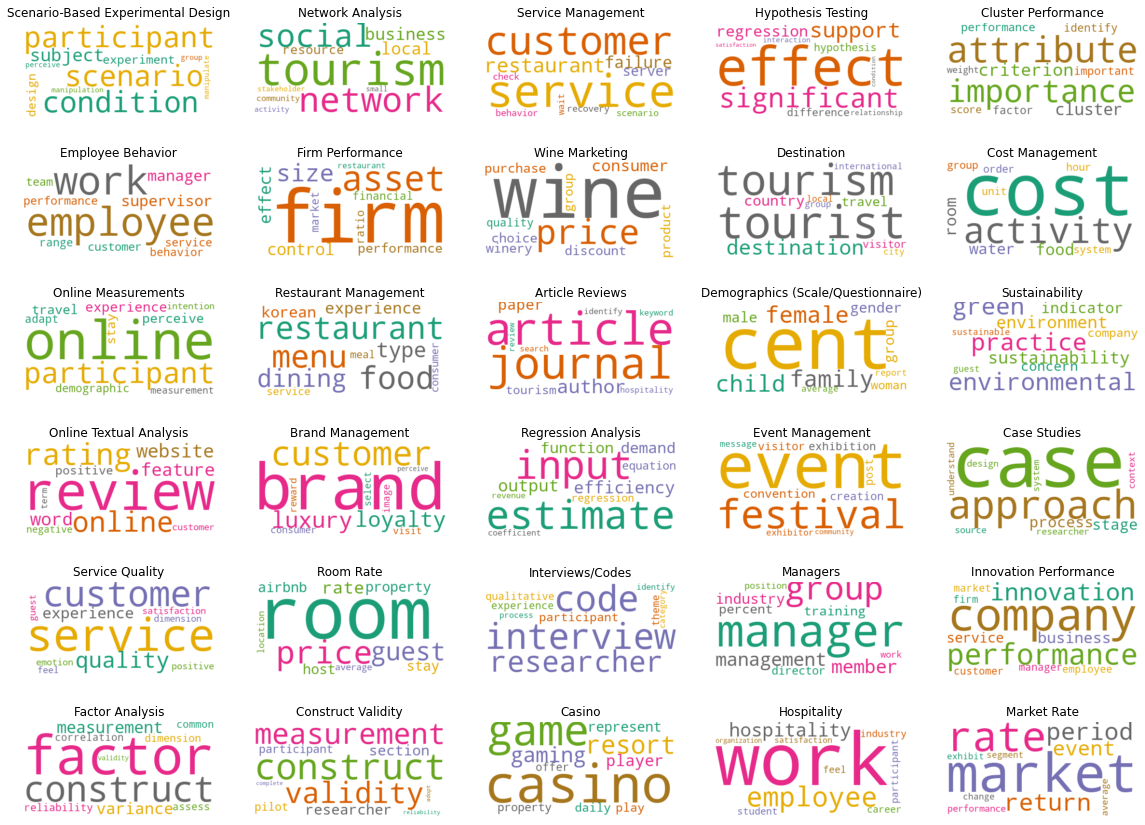

In [44]:
# Create subplots for each comedian
i=0
for i in range(num_topics):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(6, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_list[i])
    # plt.title("Topic " + str(i+1) + "\n"+ topic_list[i])

plt.show()

In [45]:
# import pyLDAvis.gensim as gensimvis
# import pyLDAvis

In [46]:
# from gensim.models.ldamodel import LdaModel
# def convertldaGenToldaMallet(mallet_model):
#     model_gensim = LdaModel(
#         id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
#         alpha=mallet_model.alpha) # original function has 'eta=0' argument
#     model_gensim.state.sstats[...] = mallet_model.wordtopics
#     model_gensim.sync_state()
#     return model_gensim

In [47]:
# new_lda = convertldaGenToldaMallet(ldamallet)

In [48]:
# vis_data = gensimvis.prepare(new_lda, corpus, id2word, sort_topics=False, n_jobs=1)
# pyLDAvis.display(vis_data)

In [49]:
labels = pd.DataFrame({"Dominant Topic":list(range(1,31)), "Labels":topic_list})
labels

,Dominant Topic,Labels
0,1,Scenario-Based Experimental Design
1,2,Network Analysis
2,3,Service Management
3,4,Hypothesis Testing
4,5,Cluster Performance
5,6,Employee Behavior
6,7,Firm Performance
7,8,Wine Marketing
8,9,Destination
9,10,Cost Management


In [50]:
corpus_topic_df = pd.DataFrame()

corpus_topic_df['Document'] = range(0, len(corpus))

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]

corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]

corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

corpus_topic_df['Title'] = df.TI

Below table shows the dominant topic, its weight and the title of each document. 

In [51]:
corpus_topic_df

,Document,Dominant Topic,Contribution %,Topic Desc,Title
0,0,20,36.62,"case, approach, process, stage, design, context, researcher, source, system, understand",Towards a hierarchy of hotel guests' in-room needs
1,1,22,32.94,"room, price, guest, rate, property, host, stay, airbnb, average, location",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty
2,2,18,34.70,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue",A meta-regression on the effect of online ratings on hotel room rates
3,3,29,31.73,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",Examining work factors after Malaysia's minimum wage implementation
4,4,1,32.88,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Seeking reward or avoiding risk from restaurant reviews: does distance matter?
...,...,...,...,...,...
3071,3071,21,25.72,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",CUSTOMER ORIENTATION OF SERVICE EMPLOYEES AND RAPPORT: INFLUENCES ON SERVICE-OUTCOME VARIABLES IN FULL-SERVICE RESTAURANTS
3072,3072,21,33.77,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",THE ROLE AND EFFECT OF JOB SATISFACTION AND EMPOWERMENT ON CUSTOMERS' PERCEPTION OF SERVICE QUALITY: A STUDY IN THE RESTAURANT INDUSTRY
3073,3073,29,37.42,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization","BURNED! THE IMPACT OF WORK ASPECTS, INJURY, AND JOB SATISFACTION ON UNIONIZED COOKS' INTENTIONS TO LEAVE THE COOKING OCCUPATION"
3074,3074,1,43.38,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",DOES CULTURAL DIFFERENCE AFFECT CUSTOMER'S RESPONSE IN A CROWDED RESTAURANT ENVIRONMENT? A COMPARISON OF AMERICAN VERSUS CHINESE CUSTOMERS


In [52]:
# corpus_topic_df.to_pickle("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/corpus_topic_df.pkl")

In [53]:
corpus_topic_df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/corpus_topic_df.pkl")
corpus_topic_df

,Document,Dominant Topic,Contribution %,Topic Desc,Title
0,0,20,36.62,"case, approach, process, stage, design, context, researcher, source, system, understand",Towards a hierarchy of hotel guests' in-room needs
1,1,22,32.94,"room, price, guest, rate, property, host, stay, airbnb, average, location",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty
2,2,18,34.70,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue",A meta-regression on the effect of online ratings on hotel room rates
3,3,29,31.73,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",Examining work factors after Malaysia's minimum wage implementation
4,4,1,32.88,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Seeking reward or avoiding risk from restaurant reviews: does distance matter?
...,...,...,...,...,...
3071,3071,21,25.72,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",The Effect Of Geographic Dispersion On The Initial And Long-Run IPO Performance
3072,3072,21,33.77,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",Temporal Analysis of Tourism Research Collaboration Network
3073,3073,29,37.42,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",The Development of Quality Standards for Rural Farm Accommodations: A Case Study in South Korea
3074,3074,1,43.38,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Understanding Chinese Overseas Recreational Vehicle Tourists: A Netnographic and Comparative Approach


In [54]:
corpus_topic_df_lables = pd.merge(corpus_topic_df, labels, left_on="Dominant Topic", right_on="Dominant Topic").sort_values('Document').reset_index(drop=True)
corpus_topic_df_lables = corpus_topic_df_lables[["Document",	"Dominant Topic",	"Labels", "Contribution %",	"Topic Desc",	"Title"]]
corpus_topic_df_lables

,Document,Dominant Topic,Labels,Contribution %,Topic Desc,Title
0,0,20,Case Studies,36.62,"case, approach, process, stage, design, context, researcher, source, system, understand",Towards a hierarchy of hotel guests' in-room needs
1,1,22,Room Rate,32.94,"room, price, guest, rate, property, host, stay, airbnb, average, location",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty
2,2,18,Regression Analysis,34.70,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue",A meta-regression on the effect of online ratings on hotel room rates
3,3,29,Hospitality,31.73,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",Examining work factors after Malaysia's minimum wage implementation
4,4,1,Scenario-Based Experimental Design,32.88,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Seeking reward or avoiding risk from restaurant reviews: does distance matter?
...,...,...,...,...,...,...
3071,3071,21,Service Quality,25.72,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",The Effect Of Geographic Dispersion On The Initial And Long-Run IPO Performance
3072,3072,21,Service Quality,33.77,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",Temporal Analysis of Tourism Research Collaboration Network
3073,3073,29,Hospitality,37.42,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",The Development of Quality Standards for Rural Farm Accommodations: A Case Study in South Korea
3074,3074,1,Scenario-Based Experimental Design,43.38,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Understanding Chinese Overseas Recreational Vehicle Tourists: A Netnographic and Comparative Approach


### Dominant Topics Distribution Across Corpus

The first thing we can do is look at the overall distribution of each topic across the corpus of research papers.

In [55]:
pd.set_option('display.max_colwidth', 200)

In [56]:
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

# topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()

topic_stats_df['Total_Docs_Perc'] = topic_stats_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus_topic_df), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]

topic_stats_df.sort_values("Total_Docs_Perc", ascending=False)

,Dominant Topic,Doc_Count,Total_Docs_Perc,Topic Desc
26,27,413,13.43,"construct, measurement, validity, researcher, section, participant, pilot, reliability, complete, adopt"
5,6,269,8.75,"employee, work, supervisor, manager, performance, team, customer, service, range, behavior"
10,11,251,8.16,"online, participant, experience, travel, perceive, stay, demographic, adapt, measurement, intention"
22,23,223,7.25,"interview, code, researcher, participant, qualitative, experience, theme, identify, process, category"
0,1,174,5.66,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive"
25,26,166,5.40,"factor, construct, measurement, variance, reliability, dimension, assess, correlation, common, validity"
6,7,143,4.65,"firm, asset, size, control, effect, performance, financial, market, ratio, restaurant"
24,25,126,4.10,"company, performance, innovation, business, service, manager, firm, employee, customer, market"
19,20,115,3.74,"case, approach, process, stage, design, context, researcher, source, system, understand"
17,18,114,3.71,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue"


In [57]:
topic_stats_df_lables = pd.merge(topic_stats_df, labels, left_on="Dominant Topic", right_on="Dominant Topic").sort_values("Total_Docs_Perc", ascending=False).reset_index(drop=True)
topic_stats_df_lables = topic_stats_df_lables[["Dominant Topic",	"Labels", "Doc_Count",	"Total_Docs_Perc",	"Topic Desc"]]
# topic_stats_df_lables.columns = ["Dominant Topic",	"Labels", "Document Count",	"Proportion (%)",	"Topic Terms"]
topic_stats_df_lables

,Dominant Topic,Labels,Doc_Count,Total_Docs_Perc,Topic Desc
0,27,Construct Validity,413,13.43,"construct, measurement, validity, researcher, section, participant, pilot, reliability, complete, adopt"
1,6,Employee Behavior,269,8.75,"employee, work, supervisor, manager, performance, team, customer, service, range, behavior"
2,11,Online Measurements,251,8.16,"online, participant, experience, travel, perceive, stay, demographic, adapt, measurement, intention"
3,23,Interviews/Codes,223,7.25,"interview, code, researcher, participant, qualitative, experience, theme, identify, process, category"
4,1,Scenario-Based Experimental Design,174,5.66,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive"
5,26,Factor Analysis,166,5.40,"factor, construct, measurement, variance, reliability, dimension, assess, correlation, common, validity"
6,7,Firm Performance,143,4.65,"firm, asset, size, control, effect, performance, financial, market, ratio, restaurant"
7,25,Innovation Performance,126,4.10,"company, performance, innovation, business, service, manager, firm, employee, customer, market"
8,20,Case Studies,115,3.74,"case, approach, process, stage, design, context, researcher, source, system, understand"
9,18,Regression Analysis,114,3.71,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue"


In [58]:
# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [59]:
# topic_stats_df_lables.to_excel("Doc_counts.xlsx")

In [60]:
# download("/content/Doc_counts.xlsx")

In [61]:
topic_counts = topic_stats_df[["Dominant Topic", 	"Doc_Count", "Total_Docs_Perc"]]
topic_counts.columns  = ["Dominant Topic", 	"Document Count", "Total Document Percentage"]
topic_counts

,Dominant Topic,Document Count,Total Document Percentage
0,1,174,5.66
1,2,27,0.88
2,3,69,2.24
3,4,24,0.78
4,5,55,1.79
5,6,269,8.75
6,7,143,4.65
7,8,32,1.04
8,9,69,2.24
9,10,38,1.24


### Relevant Research Papers per Topic Based on Dominance



In [62]:
df_dom = corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[:10])).reset_index(drop=True)

In [63]:
df_dom

,Document,Dominant Topic,Contribution %,Topic Desc,Title
0,961,1,76.71,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive","Customer perceptions of service quality in luxury hotels in New Delhi, India: an exploratory study"
1,1484,1,76.38,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Developing a new hospitality industry organizational culture scale
2,2736,1,76.29,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive","Influencing green technology use behavior in the hospitality industry and the role of the ""green champion"""
3,2432,1,72.47,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Revenue Management and Length-of-Stay-Based Room Pricing
4,1353,1,69.71,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Microbiological quality assessment of meals and work surfaces in a school-deferred catering system
...,...,...,...,...,...
295,2519,30,83.37,"market, rate, period, return, event, performance, average, change, segment, exhibit",An Evaluation of Rules for Assigning Tables to Walk-in Parties in Restaurants
296,2518,30,80.73,"market, rate, period, return, event, performance, average, change, segment, exhibit",Why Restaurants Fail? Part IV: The Relationship between Restaurant Failures and Demographic Factors
297,2465,30,80.40,"market, rate, period, return, event, performance, average, change, segment, exhibit",Understanding Perceptions of E-cigarette Use in Shared Consumption Spaces: A Schema Congruity Perspective
298,1924,30,79.86,"market, rate, period, return, event, performance, average, change, segment, exhibit",The discount effect of non-normative physical characteristics on the price of lodging properties


In [64]:
df_dom['methodology'] = df_dom.Document.apply(lambda x: df.loc[x]['methodology'])

In [65]:
df_dom

,Document,Dominant Topic,Contribution %,Topic Desc,Title,methodology
0,961,1,76.71,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive","Customer perceptions of service quality in luxury hotels in New Delhi, India: an exploratory study",3. Methodology\n3.1. Study 1: Effects of pictorial contents (food-focused vs. spokesperson-focused)\n3.1.1. Participants and design\nTo examine the impact of product-focused pictures versus spokes...
1,1484,1,76.38,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Developing a new hospitality industry organizational culture scale,"3. Study 1: Main effect of conspicuousness of decoration style\n3.1. Design, procedure, and variables\nAn experimental design was applied to examine the effects of the conspicuousness of decoratio..."
2,2736,1,76.29,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive","Influencing green technology use behavior in the hospitality industry and the role of the ""green champion""","\nMETHODS\nParticipants and Design\nTo test the hypotheses empirically, the current study adopted a 2 (powerful vs. powerless) × 2 (incidental similarity cues: present vs. absent) between-subject ..."
3,2432,1,72.47,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Revenue Management and Length-of-Stay-Based Room Pricing,"Method\nPretesting Procedures\nThe research hypotheses in the main study were tested using a 2 × 2 × 2 within-subjects experimental design with facial hair (beard vs. no beard), smile (smiling vs...."
4,1353,1,69.71,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Microbiological quality assessment of meals and work surfaces in a school-deferred catering system,"3. Methodology\n3.1. Study design and sample\nThe study employed a 2 (power: low vs. high) × 2 (appeal: belongingness vs. uniqueness) between-subjects design. A total of 139 U.S. adult consumers, ..."
...,...,...,...,...,...,...
295,2519,30,83.37,"market, rate, period, return, event, performance, average, change, segment, exhibit",An Evaluation of Rules for Assigning Tables to Walk-in Parties in Restaurants,"1\necasts, but more sophisticated analyses could also potentially\nhelp to reduce hotel restructurings and foreclosures brought\non in part by inadequately supported prospective financial\nanalyse..."
296,2518,30,80.73,"market, rate, period, return, event, performance, average, change, segment, exhibit",Why Restaurants Fail? Part IV: The Relationship between Restaurant Failures and Demographic Factors,"1\n. Empirical Methodology\nand Main Findings\nOur main tests are twofold. First, we test the significance of\nthe difference of means for event day versus non-event day\nreturns using t-tests. We..."
297,2465,30,80.40,"market, rate, period, return, event, performance, average, change, segment, exhibit",Understanding Perceptions of E-cigarette Use in Shared Consumption Spaces: A Schema Congruity Perspective,"The Data: STR\nMonthly hotel performance data on room demand, room supply, and room revenue, as well as hotel census data providing various hotel characteristics including hotel opening date, segm..."
298,1924,30,79.86,"market, rate, period, return, event, performance, average, change, segment, exhibit",The discount effect of non-normative physical characteristics on the price of lodging properties,4. Methodology\n4.1. Impact of monetary policy regime changes on hospitality index returns\nThe first regression specification documents the relationship between hospitality index returns and mone...


In [66]:
# df_dom.to_excel('/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/'+ str(num_topics) + ".xlsx")

In [67]:
# tm_results = ldamallet[corpus]

Below is the table that shows topic weights for each  document.  

In [68]:
df_e = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_e.columns = ['Topic ' + str(i) for i in range(1,num_topics+1)]
df_e

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,0.000032,0.000670,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.001308,0.001308,0.137193,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.366220,0.000032,0.083604,0.324753,0.000032,0.000032,0.000032,0.001308,0.000032,0.082967,0.000032
1,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.104940,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.170336,0.000024,0.086591,0.000024,0.080946,0.000024,0.329358,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.227264
2,0.000011,0.000011,0.000011,0.092573,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.095959,0.081285,0.000011,0.150818,0.000011,0.347003,0.000011,0.000011,0.000011,0.198905,0.032746,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000463
3,0.000023,0.000023,0.000023,0.070887,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.067276,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.305146,0.238795,0.000023,0.317332,0.000023
4,0.328791,0.000024,0.001466,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.228815,0.000024,0.110574,0.000024,0.268229,0.061548,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,0.000024,0.000024,0.000024,0.000024,0.000024,0.217343,0.000024,0.000024,0.000024,0.000024,0.225409,0.191246,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000498,0.000498,0.257200,0.000024,0.000024,0.000498,0.000024,0.092550,0.014259,0.000024,0.000024,0.000024
3072,0.000013,0.000013,0.000013,0.000013,0.000013,0.318320,0.000013,0.000013,0.000013,0.000013,0.000013,0.056723,0.000274,0.000013,0.000013,0.008898,0.008898,0.000013,0.000013,0.047837,0.337658,0.000013,0.000013,0.000013,0.011250,0.068222,0.141657,0.000013,0.000013,0.000013
3073,0.000005,0.000005,0.000005,0.132611,0.000733,0.000109,0.000005,0.020478,0.000005,0.097901,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.097797,0.000005,0.000005,0.000005,0.000005,0.000005,0.146745,0.129286,0.000005,0.374232,0.000005
3074,0.433759,0.004748,0.000024,0.000024,0.000024,0.000024,0.003803,0.000024,0.038767,0.000496,0.000024,0.072313,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.107276,0.140350,0.000024,0.002858,0.000024,0.000024,0.000024,0.195157,0.000024,0.000024,0.000024


In [69]:
# df_e.to_pickle("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/df_e.pkl")

In [70]:
df_e = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/df_e.pkl")
df_e

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,0.000032,0.000670,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.001308,0.001308,0.137193,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.366220,0.000032,0.083604,0.324753,0.000032,0.000032,0.000032,0.001308,0.000032,0.082967,0.000032
1,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.104940,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.170336,0.000024,0.086591,0.000024,0.080946,0.000024,0.329358,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.227264
2,0.000011,0.000011,0.000011,0.092573,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.095959,0.081285,0.000011,0.150818,0.000011,0.347003,0.000011,0.000011,0.000011,0.198905,0.032746,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000463
3,0.000023,0.000023,0.000023,0.070887,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.067276,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.305146,0.238795,0.000023,0.317332,0.000023
4,0.328791,0.000024,0.001466,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.228815,0.000024,0.110574,0.000024,0.268229,0.061548,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,0.000024,0.000024,0.000024,0.000024,0.000024,0.217343,0.000024,0.000024,0.000024,0.000024,0.225409,0.191246,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000498,0.000498,0.257200,0.000024,0.000024,0.000498,0.000024,0.092550,0.014259,0.000024,0.000024,0.000024
3072,0.000013,0.000013,0.000013,0.000013,0.000013,0.318320,0.000013,0.000013,0.000013,0.000013,0.000013,0.056723,0.000274,0.000013,0.000013,0.008898,0.008898,0.000013,0.000013,0.047837,0.337658,0.000013,0.000013,0.000013,0.011250,0.068222,0.141657,0.000013,0.000013,0.000013
3073,0.000005,0.000005,0.000005,0.132611,0.000733,0.000109,0.000005,0.020478,0.000005,0.097901,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.097797,0.000005,0.000005,0.000005,0.000005,0.000005,0.146745,0.129286,0.000005,0.374232,0.000005
3074,0.433759,0.004748,0.000024,0.000024,0.000024,0.000024,0.003803,0.000024,0.038767,0.000496,0.000024,0.072313,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.107276,0.140350,0.000024,0.002858,0.000024,0.000024,0.000024,0.195157,0.000024,0.000024,0.000024


In [71]:
df_e['Year'] = df.PY; df_e['Journal'] = df.JO

Below table shows the topic distribuiton on a yearly basis. It is calculated by getting the mean of topic weights of all the documents published in a given year. Since the values are so close to each other it is difficult to get trends from this table.

In [72]:
df_hot= df_e.groupby('Year').mean().T
df_hot

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Topic 1,0.035091,0.033580,0.034766,0.038004,0.042779,0.043572,0.053419,0.042560,0.046845,0.036992,0.082053
Topic 2,0.011863,0.010943,0.011940,0.012235,0.014682,0.012289,0.019183,0.015113,0.016474,0.014382,0.018784
Topic 3,0.021487,0.027893,0.026195,0.027135,0.036022,0.022301,0.015225,0.017812,0.015886,0.013794,0.026066
Topic 4,0.019254,0.020414,0.020993,0.011429,0.013540,0.017722,0.020474,0.027956,0.026137,0.025624,0.022976
Topic 5,0.022111,0.021142,0.021465,0.024765,0.027357,0.020998,0.022417,0.014736,0.016503,0.015465,0.016483
Topic 6,0.042092,0.047562,0.057562,0.082550,0.068536,0.046181,0.076393,0.070613,0.059879,0.065948,0.092268
Topic 7,0.056242,0.051733,0.045210,0.046345,0.040478,0.037643,0.029785,0.034238,0.043229,0.044645,0.003571
Topic 8,0.011323,0.016403,0.009453,0.008129,0.011924,0.010116,0.014432,0.012510,0.009455,0.006734,0.022968
Topic 9,0.032335,0.025227,0.027230,0.032929,0.032252,0.039120,0.032212,0.035684,0.038078,0.036033,0.029203
Topic 10,0.022181,0.012514,0.016743,0.018207,0.013700,0.016612,0.014800,0.010341,0.009950,0.008794,0.004391


In [73]:
df_hot["slope"] = df_hot.apply(lambda row: np.polyfit(range(2010,2021), row, deg=1)[0], axis=1)
df_hot

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,slope
Topic 1,0.035091,0.033580,0.034766,0.038004,0.042779,0.043572,0.053419,0.042560,0.046845,0.036992,0.082053,0.002768
Topic 2,0.011863,0.010943,0.011940,0.012235,0.014682,0.012289,0.019183,0.015113,0.016474,0.014382,0.018784,0.000657
Topic 3,0.021487,0.027893,0.026195,0.027135,0.036022,0.022301,0.015225,0.017812,0.015886,0.013794,0.026066,-0.000944
Topic 4,0.019254,0.020414,0.020993,0.011429,0.013540,0.017722,0.020474,0.027956,0.026137,0.025624,0.022976,0.000862
Topic 5,0.022111,0.021142,0.021465,0.024765,0.027357,0.020998,0.022417,0.014736,0.016503,0.015465,0.016483,-0.000825
Topic 6,0.042092,0.047562,0.057562,0.082550,0.068536,0.046181,0.076393,0.070613,0.059879,0.065948,0.092268,0.002867
Topic 7,0.056242,0.051733,0.045210,0.046345,0.040478,0.037643,0.029785,0.034238,0.043229,0.044645,0.003571,-0.003023
Topic 8,0.011323,0.016403,0.009453,0.008129,0.011924,0.010116,0.014432,0.012510,0.009455,0.006734,0.022968,0.000280
Topic 9,0.032335,0.025227,0.027230,0.032929,0.032252,0.039120,0.032212,0.035684,0.038078,0.036033,0.029203,0.000596
Topic 10,0.022181,0.012514,0.016743,0.018207,0.013700,0.016612,0.014800,0.010341,0.009950,0.008794,0.004391,-0.001262


In [74]:
df_hot = df_hot.sort_values("slope", ascending=False)
df_hot

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,slope
Topic 11,0.035848,0.033034,0.034619,0.039135,0.057473,0.081218,0.087003,0.080579,0.076758,0.079950,0.083061,0.006023
Topic 6,0.042092,0.047562,0.057562,0.082550,0.068536,0.046181,0.076393,0.070613,0.059879,0.065948,0.092268,0.002867
Topic 1,0.035091,0.033580,0.034766,0.038004,0.042779,0.043572,0.053419,0.042560,0.046845,0.036992,0.082053,0.002768
Topic 16,0.009128,0.006344,0.008102,0.020202,0.011484,0.024137,0.026716,0.025135,0.029478,0.031460,0.020227,0.002229
Topic 26,0.048283,0.042182,0.046553,0.048062,0.041329,0.042877,0.061603,0.074278,0.062197,0.057195,0.060115,0.002171
Topic 22,0.017666,0.032718,0.020135,0.026977,0.032242,0.030974,0.026181,0.045393,0.031777,0.040516,0.030902,0.001482
Topic 27,0.113917,0.096508,0.113381,0.099342,0.105629,0.120113,0.096517,0.102378,0.106775,0.106700,0.142911,0.001481
Topic 4,0.019254,0.020414,0.020993,0.011429,0.013540,0.017722,0.020474,0.027956,0.026137,0.025624,0.022976,0.000862
Topic 13,0.015764,0.024757,0.017025,0.014861,0.014610,0.020751,0.024667,0.017218,0.039581,0.036785,0.006554,0.000768
Topic 2,0.011863,0.010943,0.011940,0.012235,0.014682,0.012289,0.019183,0.015113,0.016474,0.014382,0.018784,0.000657


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
params = {'axes.labelsize': 10,
          'axes.titlesize': 20,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'legend.fontsize': 15}
          
plt.rcParams.update(params)

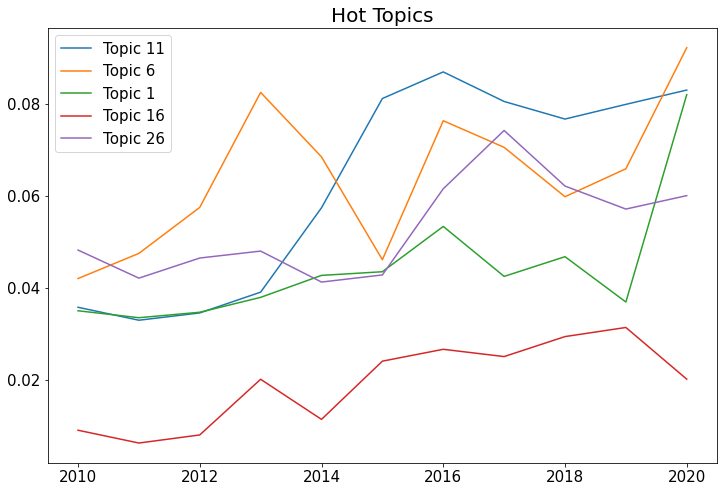

In [77]:
plt.figure(figsize=(12,8))
# labels = ["Online Reviews", "Economic Growth", "Value Creation", "Theory of Planned Behavior", "Organizational Behavior"]
for i in range(5):
  plt.plot(range(2010,2021), df_hot.drop("slope", axis=1).iloc[i], label=df_hot.index[i])
  plt.legend()
  plt.title("Hot Topics")

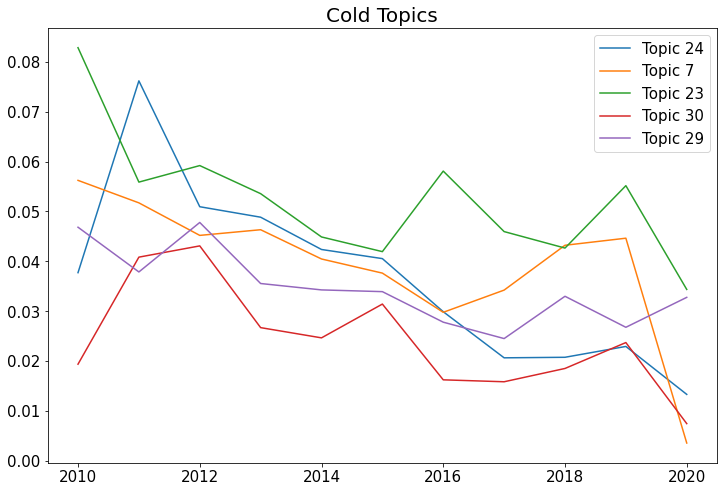

In [78]:
plt.figure(figsize=(12,8))
# labels= ["Profession & Competencies", "Market Segmentation", "Information Technology",  "Regional Entrepreneurship", "Tourism Stakeholders"]

for i in range(29,24,-1):
  plt.plot(range(2010,2021), df_hot.drop("slope", axis=1).iloc[i], label=df_hot.index[i])
  plt.legend()
  plt.title("Cold Topics")

In [79]:
df_jy = df_e.groupby(['Journal', 'Year']).mean()

Below table shows the topic distribuiton over years per journal. Even with this table the trends are not clear. 

In [80]:
df_jy

Topic 1   Topic 2   Topic 3  ...  Topic 28  Topic 29  Topic 30
Journal Year                                ...                              
CHQ     2010  0.042633  0.007194  0.061134  ...  0.000433  0.038105  0.075926
        2011  0.022435  0.013979  0.044534  ...  0.020380  0.021724  0.107908
        2012  0.027088  0.001491  0.033912  ...  0.038823  0.025066  0.085119
        2013  0.041709  0.012550  0.008321  ...  0.041435  0.032934  0.049050
        2014  0.090988  0.008935  0.043556  ...  0.000158  0.041209  0.039407
        2015  0.055681  0.022558  0.063722  ...  0.001274  0.046293  0.098124
        2016  0.165862  0.007365  0.030439  ...  0.031928  0.002106  0.053688
        2017  0.102245  0.004789  0.016723  ...  0.032607  0.014041  0.040577
        2018  0.102967  0.021126  0.042774  ...  0.007550  0.058949  0.059743
        2019  0.082931  0.002744  0.058945  ...  0.074191  0.018175  0.057472
        2020  0.125515  0.015000  0.051265  ...  0.000020  0.040421  0.019894
IJCHM   2010  0.023130  0.014486  0.003056  ...  0.002930  0.045016  0.015474
        2011  0.012522  0.010647  0.007089  ...  0.003565  0.042648  0.013895
        2012  0.024838  0.008889  0.015171  ...  0.027958  0.037494  0.040351
        2013  0.020437  0.019842  0.008520  ...  0.038666  0.027595  0.025825
        2014  0.025457  0.017284  0.018026  ...  0.028648  0.032954  0.026494
        2015  0.030976  0.011381  0.014388  ...  0.002893  0.036602  0.008389
        2016  0.016924  0.025603  0.006139  ...  0.000867  0.039073  0.008313
        2017  0.015114  0.012351  0.006129  ...  0.001110  0.017119  0.019824
        2018  0.026687  0.016158  0.008282  ...  0.003303  0.026718  0.016577
        2019  0.030379  0.014628  0.012623  ...  0.009282  0.023955  0.020707
        2020  0.031507  0.000024  0.000024  ...  0.000024  0.025125  0.000237
IJHM    2010  0.032729  0.012006  0.021086  ...  0.016186  0.048998  0.016579
        2011  0.033397  0.009026  0.028983  ...  0.032779  0.045505  0.032439
        2012  0.039613  0.015419  0.026297  ...  0.008365  0.059476  0.031402
        2013  0.034319  0.007505  0.037004  ...  0.013149  0.042954  0.025703
        2014  0.035036  0.014447  0.040925  ...  0.013542  0.036051  0.024154
        2015  0.053820  0.012247  0.021101  ...  0.005310  0.029000  0.032476
        2016  0.048037  0.016160  0.011312  ...  0.005154  0.034872  0.014196
        2017  0.062574  0.013252  0.008530  ...  0.006791  0.045582  0.005213
        2018  0.046960  0.011552  0.009786  ...  0.006751  0.041338  0.020350
        2019  0.037024  0.012821  0.011834  ...  0.005347  0.030671  0.024443
JHMM    2010  0.052040  0.002291  0.042889  ...  0.000563  0.002031  0.000176
        2015  0.030524  0.003524  0.016103  ...  0.011981  0.027880  0.009032
        2016  0.069528  0.005109  0.024589  ...  0.031455  0.003916  0.020496
        2017  0.036739  0.009911  0.053169  ...  0.005509  0.019258  0.009151
        2018  0.076806  0.015262  0.028334  ...  0.018970  0.015537  0.002318
        2019  0.016465  0.005206  0.008391  ...  0.003628  0.037163  0.007645
        2020  0.115910  0.000029  0.026311  ...  0.000098  0.048930  0.003332
JHTR    2010  0.052561  0.012967  0.027671  ...  0.000194  0.066811  0.014986
        2011  0.095073  0.014864  0.037002  ...  0.000065  0.021886  0.019766
        2012  0.034428  0.008829  0.039983  ...  0.020583  0.022919  0.073252
        2013  0.097156  0.029166  0.024614  ...  0.002946  0.003693  0.002875
        2014  0.065843  0.017519  0.041496  ...  0.014259  0.017330  0.002576
        2015  0.023621  0.014541  0.000063  ...  0.009301  0.048869  0.046769
        2016  0.061921  0.038659  0.033117  ...  0.000510  0.021415  0.006367
        2017  0.055640  0.043125  0.043850  ...  0.009156  0.014974  0.015540
        2018  0.050470  0.027264  0.027205  ...  0.006972  0.031746  0.007530
        2019  0.053704  0.033273  0.007551  ...  0.011067  0.017079  0.026571
        2020  0.003893  0.047889  0.0

### Analysis wtih Mean  

In [81]:
df_jy_melted = df_jy.reset_index().melt(id_vars=['Journal', 'Year'], value_vars=['Topic ' + str(i) for i in range(1,31)], var_name='Topic', value_name='Average')
df_jy_melted.sort_values(["Journal", "Year"]).head(60)

,Journal,Year,Topic,Average
0,CHQ,2010,Topic 1,0.042633
50,CHQ,2010,Topic 2,0.007194
100,CHQ,2010,Topic 3,0.061134
150,CHQ,2010,Topic 4,0.009489
200,CHQ,2010,Topic 5,0.006860
250,CHQ,2010,Topic 6,0.057907
300,CHQ,2010,Topic 7,0.011070
350,CHQ,2010,Topic 8,0.007265
400,CHQ,2010,Topic 9,0.016745
450,CHQ,2010,Topic 10,0.021622


In [82]:
df_jy

Topic 1   Topic 2   Topic 3  ...  Topic 28  Topic 29  Topic 30
Journal Year                                ...                              
CHQ     2010  0.042633  0.007194  0.061134  ...  0.000433  0.038105  0.075926
        2011  0.022435  0.013979  0.044534  ...  0.020380  0.021724  0.107908
        2012  0.027088  0.001491  0.033912  ...  0.038823  0.025066  0.085119
        2013  0.041709  0.012550  0.008321  ...  0.041435  0.032934  0.049050
        2014  0.090988  0.008935  0.043556  ...  0.000158  0.041209  0.039407
        2015  0.055681  0.022558  0.063722  ...  0.001274  0.046293  0.098124
        2016  0.165862  0.007365  0.030439  ...  0.031928  0.002106  0.053688
        2017  0.102245  0.004789  0.016723  ...  0.032607  0.014041  0.040577
        2018  0.102967  0.021126  0.042774  ...  0.007550  0.058949  0.059743
        2019  0.082931  0.002744  0.058945  ...  0.074191  0.018175  0.057472
        2020  0.125515  0.015000  0.051265  ...  0.000020  0.040421  0.019894
IJCHM   2010  0.023130  0.014486  0.003056  ...  0.002930  0.045016  0.015474
        2011  0.012522  0.010647  0.007089  ...  0.003565  0.042648  0.013895
        2012  0.024838  0.008889  0.015171  ...  0.027958  0.037494  0.040351
        2013  0.020437  0.019842  0.008520  ...  0.038666  0.027595  0.025825
        2014  0.025457  0.017284  0.018026  ...  0.028648  0.032954  0.026494
        2015  0.030976  0.011381  0.014388  ...  0.002893  0.036602  0.008389
        2016  0.016924  0.025603  0.006139  ...  0.000867  0.039073  0.008313
        2017  0.015114  0.012351  0.006129  ...  0.001110  0.017119  0.019824
        2018  0.026687  0.016158  0.008282  ...  0.003303  0.026718  0.016577
        2019  0.030379  0.014628  0.012623  ...  0.009282  0.023955  0.020707
        2020  0.031507  0.000024  0.000024  ...  0.000024  0.025125  0.000237
IJHM    2010  0.032729  0.012006  0.021086  ...  0.016186  0.048998  0.016579
        2011  0.033397  0.009026  0.028983  ...  0.032779  0.045505  0.032439
        2012  0.039613  0.015419  0.026297  ...  0.008365  0.059476  0.031402
        2013  0.034319  0.007505  0.037004  ...  0.013149  0.042954  0.025703
        2014  0.035036  0.014447  0.040925  ...  0.013542  0.036051  0.024154
        2015  0.053820  0.012247  0.021101  ...  0.005310  0.029000  0.032476
        2016  0.048037  0.016160  0.011312  ...  0.005154  0.034872  0.014196
        2017  0.062574  0.013252  0.008530  ...  0.006791  0.045582  0.005213
        2018  0.046960  0.011552  0.009786  ...  0.006751  0.041338  0.020350
        2019  0.037024  0.012821  0.011834  ...  0.005347  0.030671  0.024443
JHMM    2010  0.052040  0.002291  0.042889  ...  0.000563  0.002031  0.000176
        2015  0.030524  0.003524  0.016103  ...  0.011981  0.027880  0.009032
        2016  0.069528  0.005109  0.024589  ...  0.031455  0.003916  0.020496
        2017  0.036739  0.009911  0.053169  ...  0.005509  0.019258  0.009151
        2018  0.076806  0.015262  0.028334  ...  0.018970  0.015537  0.002318
        2019  0.016465  0.005206  0.008391  ...  0.003628  0.037163  0.007645
        2020  0.115910  0.000029  0.026311  ...  0.000098  0.048930  0.003332
JHTR    2010  0.052561  0.012967  0.027671  ...  0.000194  0.066811  0.014986
        2011  0.095073  0.014864  0.037002  ...  0.000065  0.021886  0.019766
        2012  0.034428  0.008829  0.039983  ...  0.020583  0.022919  0.073252
        2013  0.097156  0.029166  0.024614  ...  0.002946  0.003693  0.002875
        2014  0.065843  0.017519  0.041496  ...  0.014259  0.017330  0.002576
        2015  0.023621  0.014541  0.000063  ...  0.009301  0.048869  0.046769
        2016  0.061921  0.038659  0.033117  ...  0.000510  0.021415  0.006367
        2017  0.055640  0.043125  0.043850  ...  0.009156  0.014974  0.015540
        2018  0.050470  0.027264  0.027205  ...  0.006972  0.031746  0.007530
        2019  0.053704  0.033273  0.007551  ...  0.011067  0.017079  0.026571
        2020  0.003893  0.047889  0.0

### CLUSTERMAP

In [83]:
df_jy

Topic 1   Topic 2   Topic 3  ...  Topic 28  Topic 29  Topic 30
Journal Year                                ...                              
CHQ     2010  0.042633  0.007194  0.061134  ...  0.000433  0.038105  0.075926
        2011  0.022435  0.013979  0.044534  ...  0.020380  0.021724  0.107908
        2012  0.027088  0.001491  0.033912  ...  0.038823  0.025066  0.085119
        2013  0.041709  0.012550  0.008321  ...  0.041435  0.032934  0.049050
        2014  0.090988  0.008935  0.043556  ...  0.000158  0.041209  0.039407
        2015  0.055681  0.022558  0.063722  ...  0.001274  0.046293  0.098124
        2016  0.165862  0.007365  0.030439  ...  0.031928  0.002106  0.053688
        2017  0.102245  0.004789  0.016723  ...  0.032607  0.014041  0.040577
        2018  0.102967  0.021126  0.042774  ...  0.007550  0.058949  0.059743
        2019  0.082931  0.002744  0.058945  ...  0.074191  0.018175  0.057472
        2020  0.125515  0.015000  0.051265  ...  0.000020  0.040421  0.019894
IJCHM   2010  0.023130  0.014486  0.003056  ...  0.002930  0.045016  0.015474
        2011  0.012522  0.010647  0.007089  ...  0.003565  0.042648  0.013895
        2012  0.024838  0.008889  0.015171  ...  0.027958  0.037494  0.040351
        2013  0.020437  0.019842  0.008520  ...  0.038666  0.027595  0.025825
        2014  0.025457  0.017284  0.018026  ...  0.028648  0.032954  0.026494
        2015  0.030976  0.011381  0.014388  ...  0.002893  0.036602  0.008389
        2016  0.016924  0.025603  0.006139  ...  0.000867  0.039073  0.008313
        2017  0.015114  0.012351  0.006129  ...  0.001110  0.017119  0.019824
        2018  0.026687  0.016158  0.008282  ...  0.003303  0.026718  0.016577
        2019  0.030379  0.014628  0.012623  ...  0.009282  0.023955  0.020707
        2020  0.031507  0.000024  0.000024  ...  0.000024  0.025125  0.000237
IJHM    2010  0.032729  0.012006  0.021086  ...  0.016186  0.048998  0.016579
        2011  0.033397  0.009026  0.028983  ...  0.032779  0.045505  0.032439
        2012  0.039613  0.015419  0.026297  ...  0.008365  0.059476  0.031402
        2013  0.034319  0.007505  0.037004  ...  0.013149  0.042954  0.025703
        2014  0.035036  0.014447  0.040925  ...  0.013542  0.036051  0.024154
        2015  0.053820  0.012247  0.021101  ...  0.005310  0.029000  0.032476
        2016  0.048037  0.016160  0.011312  ...  0.005154  0.034872  0.014196
        2017  0.062574  0.013252  0.008530  ...  0.006791  0.045582  0.005213
        2018  0.046960  0.011552  0.009786  ...  0.006751  0.041338  0.020350
        2019  0.037024  0.012821  0.011834  ...  0.005347  0.030671  0.024443
JHMM    2010  0.052040  0.002291  0.042889  ...  0.000563  0.002031  0.000176
        2015  0.030524  0.003524  0.016103  ...  0.011981  0.027880  0.009032
        2016  0.069528  0.005109  0.024589  ...  0.031455  0.003916  0.020496
        2017  0.036739  0.009911  0.053169  ...  0.005509  0.019258  0.009151
        2018  0.076806  0.015262  0.028334  ...  0.018970  0.015537  0.002318
        2019  0.016465  0.005206  0.008391  ...  0.003628  0.037163  0.007645
        2020  0.115910  0.000029  0.026311  ...  0.000098  0.048930  0.003332
JHTR    2010  0.052561  0.012967  0.027671  ...  0.000194  0.066811  0.014986
        2011  0.095073  0.014864  0.037002  ...  0.000065  0.021886  0.019766
        2012  0.034428  0.008829  0.039983  ...  0.020583  0.022919  0.073252
        2013  0.097156  0.029166  0.024614  ...  0.002946  0.003693  0.002875
        2014  0.065843  0.017519  0.041496  ...  0.014259  0.017330  0.002576
        2015  0.023621  0.014541  0.000063  ...  0.009301  0.048869  0.046769
        2016  0.061921  0.038659  0.033117  ...  0.000510  0.021415  0.006367
        2017  0.055640  0.043125  0.043850  ...  0.009156  0.014974  0.015540
        2018  0.050470  0.027264  0.027205  ...  0.006972  0.031746  0.007530
        2019  0.053704  0.033273  0.007551  ...  0.011067  0.017079  0.026571
        2020  0.003893  0.047889  0.0

In [84]:
df_cm = df_jy.reset_index()

In [85]:
d= df_cm.groupby("Journal").mean()

In [86]:
d.drop("Year", axis=1, inplace=True)
d

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Journal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHQ,0.078187,0.010703,0.041393,0.036017,0.020668,0.063496,0.044864,0.023423,0.017730,0.018577,0.045367,0.026974,0.014232,0.015672,0.022611,0.018988,0.016104,0.059862,0.004766,0.042391,0.020218,0.048543,0.018119,0.043232,0.033610,0.050442,0.047926,0.022618,0.030820,0.062446
IJCHM,0.023452,0.013754,0.009041,0.015512,0.014775,0.122257,0.033779,0.006988,0.027185,0.008935,0.051134,0.025924,0.026978,0.025054,0.010807,0.015581,0.013966,0.030027,0.008971,0.069988,0.028509,0.023844,0.071079,0.041313,0.048124,0.045383,0.126766,0.010841,0.032209,0.017826
IJHM,0.042351,0.012444,0.021686,0.020710,0.021978,0.063273,0.051723,0.011334,0.025937,0.018275,0.057113,0.045969,0.015090,0.011456,0.015459,0.018756,0.016025,0.041942,0.009283,0.049953,0.036072,0.034188,0.048309,0.036645,0.043837,0.051179,0.103535,0.011337,0.041445,0.022695
JHMM,0.056859,0.005905,0.028541,0.022687,0.015412,0.047410,0.008093,0.010173,0.038347,0.005507,0.104993,0.027425,0.028792,0.005649,0.014373,0.037251,0.023127,0.020749,0.012664,0.037768,0.059690,0.021697,0.052460,0.028870,0.026171,0.059815,0.159705,0.010315,0.022102,0.007450
JHTR,0.054028,0.026191,0.025943,0.016061,0.024961,0.036051,0.029920,0.011291,0.075870,0.012475,0.087679,0.029705,0.036056,0.014614,0.010117,0.017933,0.020061,0.033740,0.019255,0.049980,0.023306,0.018306,0.056439,0.028791,0.016768,0.061383,0.110272,0.008265,0.024879,0.019660


In [87]:
d_1 = d.reset_index()


In [88]:
d_1

,Journal,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,CHQ,0.078187,0.010703,0.041393,0.036017,0.020668,0.063496,0.044864,0.023423,0.017730,0.018577,0.045367,0.026974,0.014232,0.015672,0.022611,0.018988,0.016104,0.059862,0.004766,0.042391,0.020218,0.048543,0.018119,0.043232,0.033610,0.050442,0.047926,0.022618,0.030820,0.062446
1,IJCHM,0.023452,0.013754,0.009041,0.015512,0.014775,0.122257,0.033779,0.006988,0.027185,0.008935,0.051134,0.025924,0.026978,0.025054,0.010807,0.015581,0.013966,0.030027,0.008971,0.069988,0.028509,0.023844,0.071079,0.041313,0.048124,0.045383,0.126766,0.010841,0.032209,0.017826
2,IJHM,0.042351,0.012444,0.021686,0.020710,0.021978,0.063273,0.051723,0.011334,0.025937,0.018275,0.057113,0.045969,0.015090,0.011456,0.015459,0.018756,0.016025,0.041942,0.009283,0.049953,0.036072,0.034188,0.048309,0.036645,0.043837,0.051179,0.103535,0.011337,0.041445,0.022695
3,JHMM,0.056859,0.005905,0.028541,0.022687,0.015412,0.047410,0.008093,0.010173,0.038347,0.005507,0.104993,0.027425,0.028792,0.005649,0.014373,0.037251,0.023127,0.020749,0.012664,0.037768,0.059690,0.021697,0.052460,0.028870,0.026171,0.059815,0.159705,0.010315,0.022102,0.007450
4,JHTR,0.054028,0.026191,0.025943,0.016061,0.024961,0.036051,0.029920,0.011291,0.075870,0.012475,0.087679,0.029705,0.036056,0.014614,0.010117,0.017933,0.020061,0.033740,0.019255,0.049980,0.023306,0.018306,0.056439,0.028791,0.016768,0.061383,0.110272,0.008265,0.024879,0.019660


In [89]:
d_1.set_index("Journal", inplace=True)

In [90]:
d_1

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Journal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHQ,0.078187,0.010703,0.041393,0.036017,0.020668,0.063496,0.044864,0.023423,0.017730,0.018577,0.045367,0.026974,0.014232,0.015672,0.022611,0.018988,0.016104,0.059862,0.004766,0.042391,0.020218,0.048543,0.018119,0.043232,0.033610,0.050442,0.047926,0.022618,0.030820,0.062446
IJCHM,0.023452,0.013754,0.009041,0.015512,0.014775,0.122257,0.033779,0.006988,0.027185,0.008935,0.051134,0.025924,0.026978,0.025054,0.010807,0.015581,0.013966,0.030027,0.008971,0.069988,0.028509,0.023844,0.071079,0.041313,0.048124,0.045383,0.126766,0.010841,0.032209,0.017826
IJHM,0.042351,0.012444,0.021686,0.020710,0.021978,0.063273,0.051723,0.011334,0.025937,0.018275,0.057113,0.045969,0.015090,0.011456,0.015459,0.018756,0.016025,0.041942,0.009283,0.049953,0.036072,0.034188,0.048309,0.036645,0.043837,0.051179,0.103535,0.011337,0.041445,0.022695
JHMM,0.056859,0.005905,0.028541,0.022687,0.015412,0.047410,0.008093,0.010173,0.038347,0.005507,0.104993,0.027425,0.028792,0.005649,0.014373,0.037251,0.023127,0.020749,0.012664,0.037768,0.059690,0.021697,0.052460,0.028870,0.026171,0.059815,0.159705,0.010315,0.022102,0.007450
JHTR,0.054028,0.026191,0.025943,0.016061,0.024961,0.036051,0.029920,0.011291,0.075870,0.012475,0.087679,0.029705,0.036056,0.014614,0.010117,0.017933,0.020061,0.033740,0.019255,0.049980,0.023306,0.018306,0.056439,0.028791,0.016768,0.061383,0.110272,0.008265,0.024879,0.019660


In [91]:
# params = {'axes.labelsize': 10,
#           'axes.titlesize': 20,
#           'xtick.labelsize': 15,
#           'ytick.labelsize': 15,
#           'legend.fontsize': 5}
          
# plt.rcParams.update(params)

In [92]:
sns.set(font_scale=1)

In [93]:
# dpi = 72
# cellSizePixels = 250

In [94]:
# dpi = plt.rcParams['figure.dpi']
# marginWidth = plt.rcParams['figure.subplot.right']-plt.rcParams['figure.subplot.left']
# marginHeight = plt.rcParams['figure.subplot.top']-plt.rcParams['figure.subplot.bottom']
# Ny,Nx = d.shape
# figWidth = (Nx*cellSizePixels/dpi)/0.8/marginWidth
# figHeigh = (Ny*cellSizePixels/dpi)/0.8/marginHeight

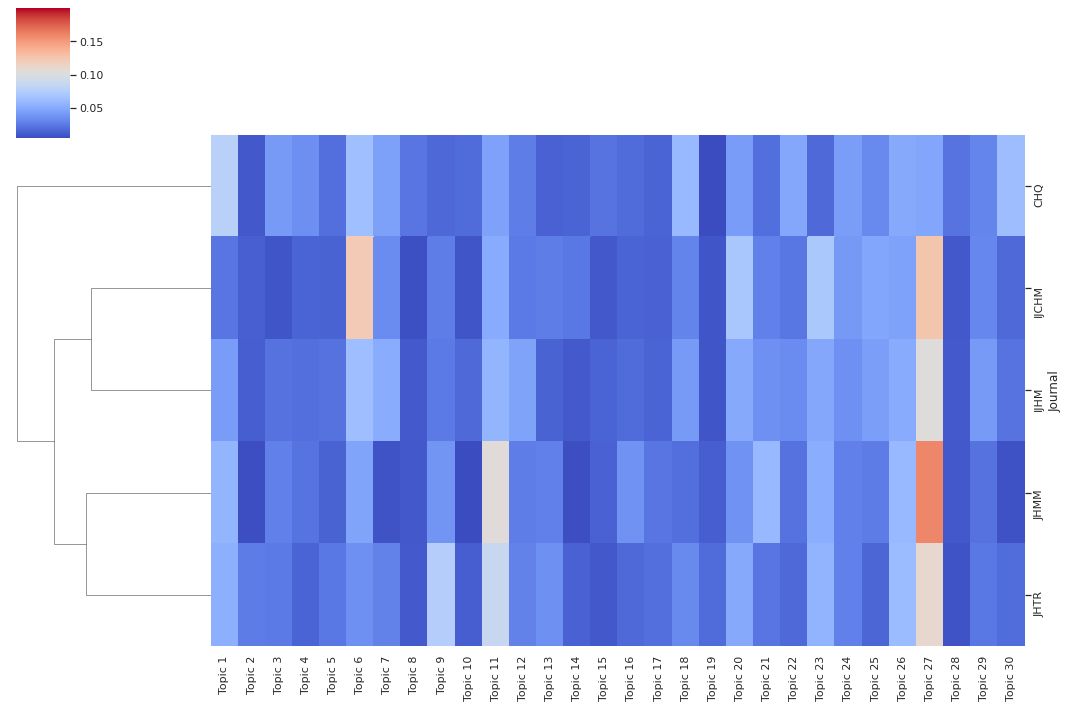

In [95]:
# plt.figure(figsize=(120,120))
# sns.clustermap(d,cmap='coolwarm',standard_scale=1);

sns.clustermap(data=d_1, cmap="coolwarm", figsize=(15,10), col_cluster=False, dendrogram_ratio=(.2, .2),  vmax=0.2, cbar_kws={"ticks":[0.05, 0.10, 0.15]})
plt.savefig('cm.jpg',
            dpi=150 )

In [96]:
# plt.savefig('cm.jpg',
#             dpi=150 )

In [97]:
# params = {'axes.labelsize': 20,
#           'axes.titlesize': 25,
#           'xtick.labelsize': 20,
#           'ytick.labelsize': 20,
#           'legend.fontsize': 30}
          
# plt.rcParams.update(params)

# plt.figure(figsize=(40,120))

# for i,j in enumerate(df_jy.index.levels[0]):
  
#   plt.subplot(10, 2, i+1)
#   plt.stackplot(df_jy.xs(j, level=0).index, df_jy.xs(j, level=0).reset_index().drop("Year", axis=1).T, labels=df_jy.columns)  
#   plt.title(j)
#   # plt.legend(loc='upper left')
#   if i==9: plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
#   if i ==18: break




In [98]:
# plt.figure(figsize=(30,60))

# for i, j in enumerate(df_jy_melted.Journal.unique()):
  
#   plt.subplot(7, 3, i+1)
 
#   Y= [df_jy_melted.query("Journal==@j & Topic ==@topic")["Average"].tolist() for topic in ['Topic ' + str(a) for a in range(1,51)]]

#   if j == "TOURISM MANAGEMENT PERSPECTIVES":
#     plt.stackplot(range(2012,2021), *Y)
#   else:
#     plt.stackplot(range(2011,2021), *Y)
#   plt.title(j)
#   if i ==19:
#     break


In [99]:
df_jy

Topic 1   Topic 2   Topic 3  ...  Topic 28  Topic 29  Topic 30
Journal Year                                ...                              
CHQ     2010  0.042633  0.007194  0.061134  ...  0.000433  0.038105  0.075926
        2011  0.022435  0.013979  0.044534  ...  0.020380  0.021724  0.107908
        2012  0.027088  0.001491  0.033912  ...  0.038823  0.025066  0.085119
        2013  0.041709  0.012550  0.008321  ...  0.041435  0.032934  0.049050
        2014  0.090988  0.008935  0.043556  ...  0.000158  0.041209  0.039407
        2015  0.055681  0.022558  0.063722  ...  0.001274  0.046293  0.098124
        2016  0.165862  0.007365  0.030439  ...  0.031928  0.002106  0.053688
        2017  0.102245  0.004789  0.016723  ...  0.032607  0.014041  0.040577
        2018  0.102967  0.021126  0.042774  ...  0.007550  0.058949  0.059743
        2019  0.082931  0.002744  0.058945  ...  0.074191  0.018175  0.057472
        2020  0.125515  0.015000  0.051265  ...  0.000020  0.040421  0.019894
IJCHM   2010  0.023130  0.014486  0.003056  ...  0.002930  0.045016  0.015474
        2011  0.012522  0.010647  0.007089  ...  0.003565  0.042648  0.013895
        2012  0.024838  0.008889  0.015171  ...  0.027958  0.037494  0.040351
        2013  0.020437  0.019842  0.008520  ...  0.038666  0.027595  0.025825
        2014  0.025457  0.017284  0.018026  ...  0.028648  0.032954  0.026494
        2015  0.030976  0.011381  0.014388  ...  0.002893  0.036602  0.008389
        2016  0.016924  0.025603  0.006139  ...  0.000867  0.039073  0.008313
        2017  0.015114  0.012351  0.006129  ...  0.001110  0.017119  0.019824
        2018  0.026687  0.016158  0.008282  ...  0.003303  0.026718  0.016577
        2019  0.030379  0.014628  0.012623  ...  0.009282  0.023955  0.020707
        2020  0.031507  0.000024  0.000024  ...  0.000024  0.025125  0.000237
IJHM    2010  0.032729  0.012006  0.021086  ...  0.016186  0.048998  0.016579
        2011  0.033397  0.009026  0.028983  ...  0.032779  0.045505  0.032439
        2012  0.039613  0.015419  0.026297  ...  0.008365  0.059476  0.031402
        2013  0.034319  0.007505  0.037004  ...  0.013149  0.042954  0.025703
        2014  0.035036  0.014447  0.040925  ...  0.013542  0.036051  0.024154
        2015  0.053820  0.012247  0.021101  ...  0.005310  0.029000  0.032476
        2016  0.048037  0.016160  0.011312  ...  0.005154  0.034872  0.014196
        2017  0.062574  0.013252  0.008530  ...  0.006791  0.045582  0.005213
        2018  0.046960  0.011552  0.009786  ...  0.006751  0.041338  0.020350
        2019  0.037024  0.012821  0.011834  ...  0.005347  0.030671  0.024443
JHMM    2010  0.052040  0.002291  0.042889  ...  0.000563  0.002031  0.000176
        2015  0.030524  0.003524  0.016103  ...  0.011981  0.027880  0.009032
        2016  0.069528  0.005109  0.024589  ...  0.031455  0.003916  0.020496
        2017  0.036739  0.009911  0.053169  ...  0.005509  0.019258  0.009151
        2018  0.076806  0.015262  0.028334  ...  0.018970  0.015537  0.002318
        2019  0.016465  0.005206  0.008391  ...  0.003628  0.037163  0.007645
        2020  0.115910  0.000029  0.026311  ...  0.000098  0.048930  0.003332
JHTR    2010  0.052561  0.012967  0.027671  ...  0.000194  0.066811  0.014986
        2011  0.095073  0.014864  0.037002  ...  0.000065  0.021886  0.019766
        2012  0.034428  0.008829  0.039983  ...  0.020583  0.022919  0.073252
        2013  0.097156  0.029166  0.024614  ...  0.002946  0.003693  0.002875
        2014  0.065843  0.017519  0.041496  ...  0.014259  0.017330  0.002576
        2015  0.023621  0.014541  0.000063  ...  0.009301  0.048869  0.046769
        2016  0.061921  0.038659  0.033117  ...  0.000510  0.021415  0.006367
        2017  0.055640  0.043125  0.043850  ...  0.009156  0.014974  0.015540
        2018  0.050470  0.027264  0.027205  ...  0.006972  0.031746  0.007530
        2019  0.053704  0.033273  0.007551  ...  0.011067  0.017079  0.026571
        2020  0.003893  0.047889  0.0

In [100]:
# df_tem = pd.DataFrame()
# df_tem["Av"] = df_jy.xs(j, level=0).mean(axis=0).values

In [101]:
# df_tem

In [102]:
df_highest = pd.DataFrame()
for j in df_jy.index.levels[0]:
  
  df_temp = pd.DataFrame()
  df_temp["Topic"] = df_jy.xs(j, level=0).mean(axis=0).index
  df_temp["Average"] = df_jy.xs(j, level=0).mean(axis=0).values
  df_temp["Journal"]= j
  df_highest = pd.concat([df_highest, df_temp], axis=0)

In [103]:
df_highest

,Topic,Average,Journal
0,Topic 1,0.078187,CHQ
1,Topic 2,0.010703,CHQ
2,Topic 3,0.041393,CHQ
3,Topic 4,0.036017,CHQ
4,Topic 5,0.020668,CHQ
...,...,...,...
25,Topic 26,0.061383,JHTR
26,Topic 27,0.110272,JHTR
27,Topic 28,0.008265,JHTR
28,Topic 29,0.024879,JHTR


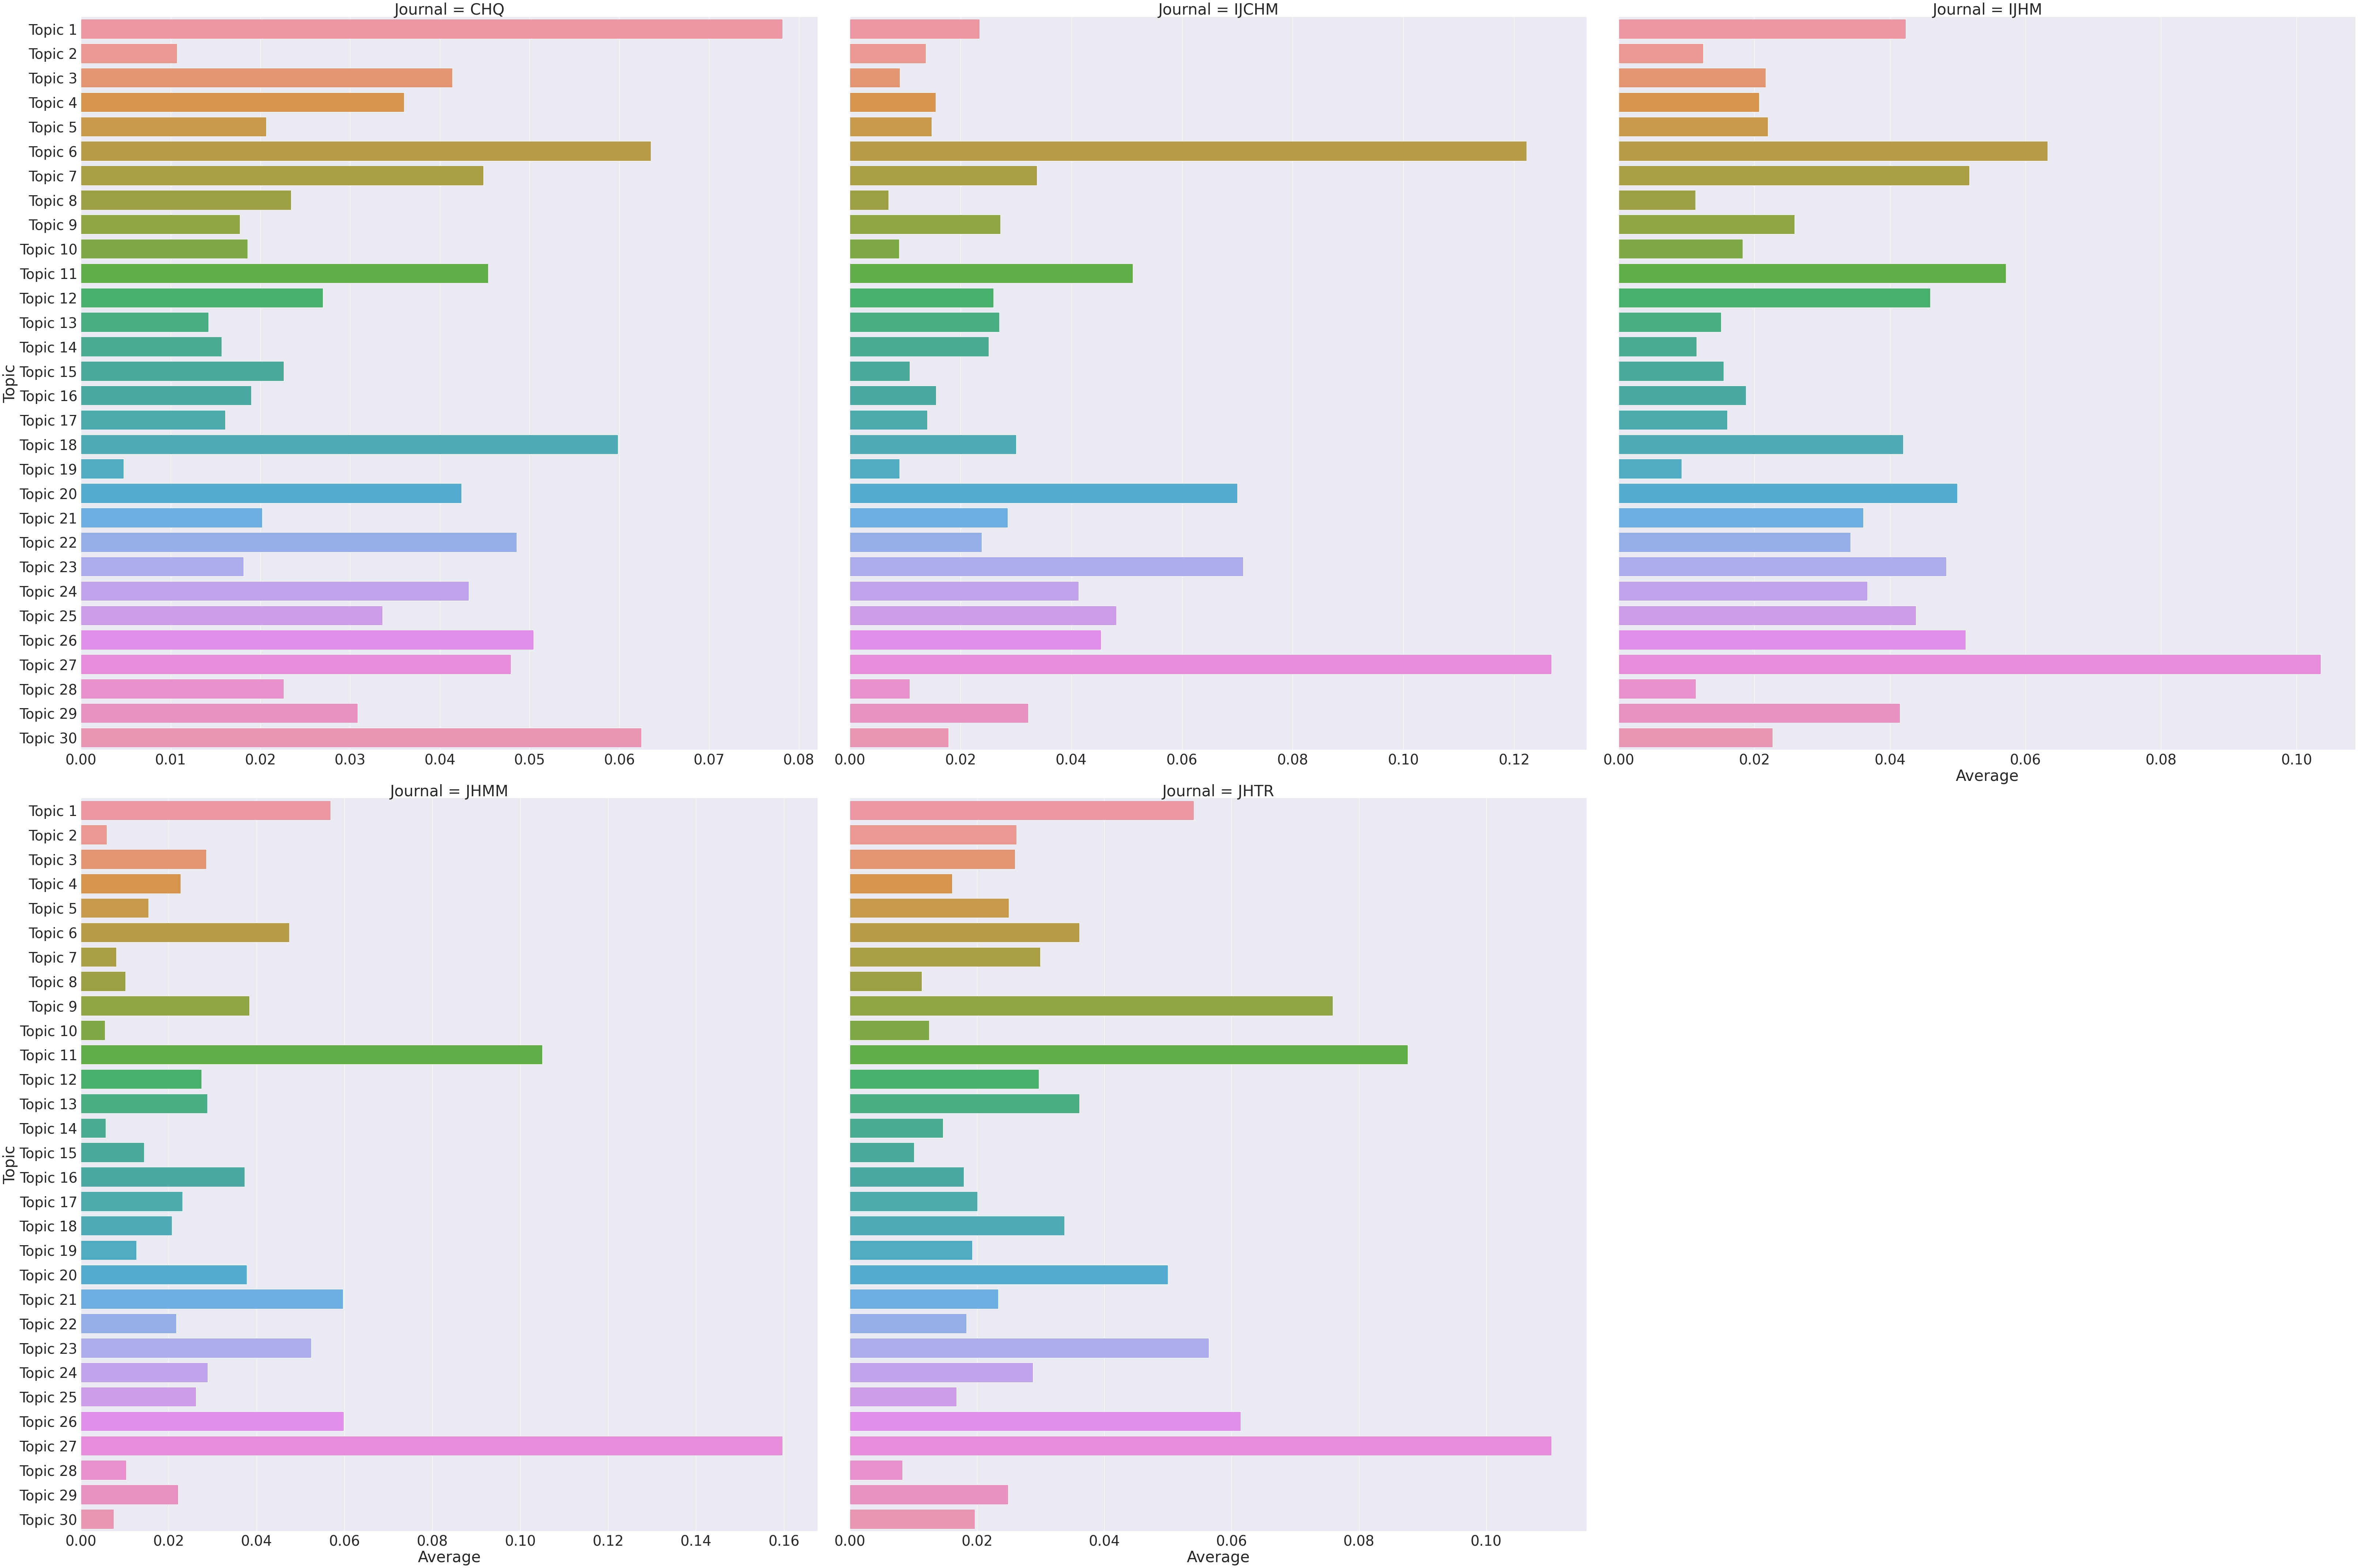

In [104]:
sns.set(font_scale=3.5)
sns.catplot(data=df_highest, x="Average", y= 'Topic', col="Journal", col_wrap=3, sharex=False, height=30, kind='bar');
# plt.savefig("doc.jpeg")

In [105]:
# download("/content/doc.jpeg")

In [106]:
df_highest

,Topic,Average,Journal
0,Topic 1,0.078187,CHQ
1,Topic 2,0.010703,CHQ
2,Topic 3,0.041393,CHQ
3,Topic 4,0.036017,CHQ
4,Topic 5,0.020668,CHQ
...,...,...,...
25,Topic 26,0.061383,JHTR
26,Topic 27,0.110272,JHTR
27,Topic 28,0.008265,JHTR
28,Topic 29,0.024879,JHTR


In [107]:
df_highest["rank"] = df_highest.groupby("Journal")["Average"].rank(ascending=False)

In [108]:
df_highest

,Topic,Average,Journal,rank
0,Topic 1,0.078187,CHQ,1.0
1,Topic 2,0.010703,CHQ,29.0
2,Topic 3,0.041393,CHQ,12.0
3,Topic 4,0.036017,CHQ,13.0
4,Topic 5,0.020668,CHQ,20.0
...,...,...,...,...
25,Topic 26,0.061383,JHTR,4.0
26,Topic 27,0.110272,JHTR,1.0
27,Topic 28,0.008265,JHTR,30.0
28,Topic 29,0.024879,JHTR,17.0


In [109]:
df_highest.loc[df_highest["rank"]>3, "Average"] =0
df_highest

,Topic,Average,Journal,rank
0,Topic 1,0.078187,CHQ,1.0
1,Topic 2,0.000000,CHQ,29.0
2,Topic 3,0.000000,CHQ,12.0
3,Topic 4,0.000000,CHQ,13.0
4,Topic 5,0.000000,CHQ,20.0
...,...,...,...,...
25,Topic 26,0.000000,JHTR,4.0
26,Topic 27,0.110272,JHTR,1.0
27,Topic 28,0.000000,JHTR,30.0
28,Topic 29,0.000000,JHTR,17.0


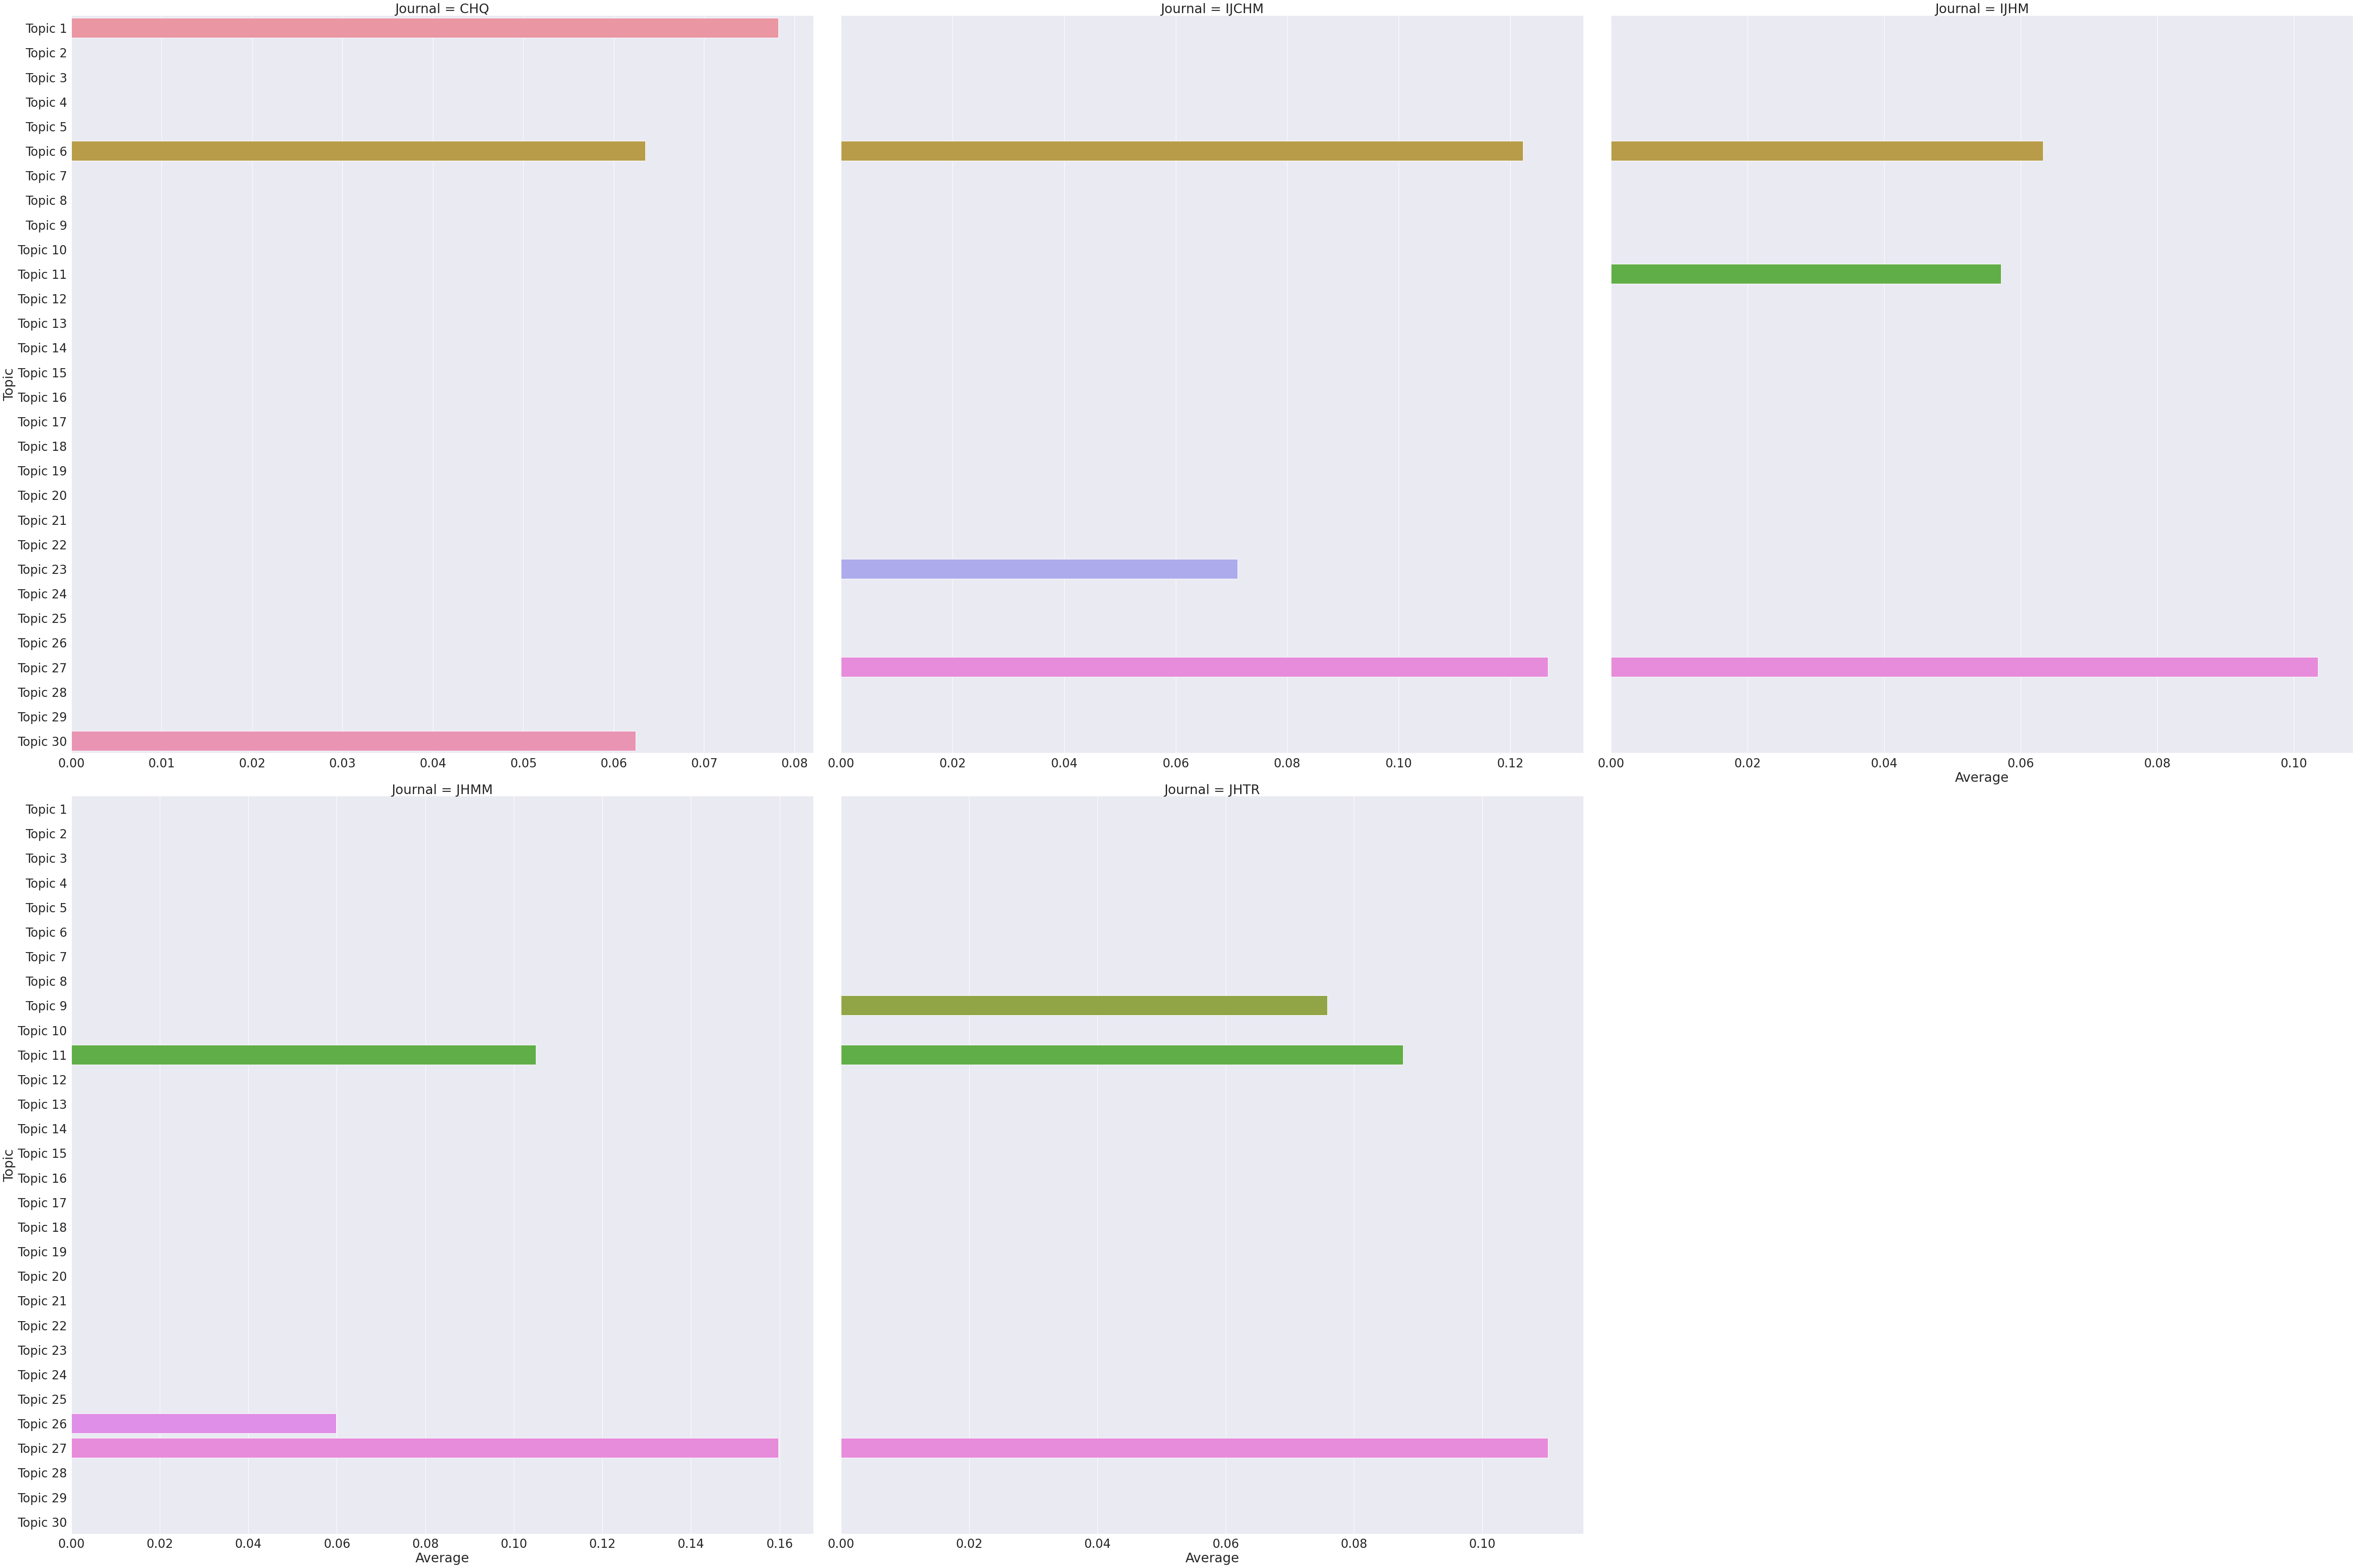

In [110]:
sns.set(font_scale=2.5)
sns.catplot(data=df_highest, x="Average", y= 'Topic', col="Journal", col_wrap=3, sharex=False, height=25, kind='bar');

In [111]:
df_largest = pd.DataFrame()
for j in df_jy.index.levels[0]:
  
  df_temp = pd.DataFrame()
  df_temp["Topic"] = df_jy.xs(j, level=0).mean(axis=0).nlargest(3).index
  df_temp["Average"] = df_jy.xs(j, level=0).mean(axis=0).nlargest(3).values
  df_temp["Journal"]= j
  df_largest = pd.concat([df_largest, df_temp], axis=0)

In [112]:
df_largest

,Topic,Average,Journal
0,Topic 1,0.078187,CHQ
1,Topic 6,0.063496,CHQ
2,Topic 30,0.062446,CHQ
0,Topic 27,0.126766,IJCHM
1,Topic 6,0.122257,IJCHM
2,Topic 23,0.071079,IJCHM
0,Topic 27,0.103535,IJHM
1,Topic 6,0.063273,IJHM
2,Topic 11,0.057113,IJHM
0,Topic 27,0.159705,JHMM


In [113]:
large_labels = labels.copy()
large_labels.columns = ["Topic", "Labels"]
large_labels["Topic"] =large_labels["Topic"].astype("str")
large_labels["Topic"] = "Topic " + large_labels.Topic
large_labels 

,Topic,Labels
0,Topic 1,Scenario-Based Experimental Design
1,Topic 2,Network Analysis
2,Topic 3,Service Management
3,Topic 4,Hypothesis Testing
4,Topic 5,Cluster Performance
5,Topic 6,Employee Behavior
6,Topic 7,Firm Performance
7,Topic 8,Wine Marketing
8,Topic 9,Destination
9,Topic 10,Cost Management


In [114]:
df_largest = pd.merge(df_largest, large_labels).sort_values(["Journal", "Average"], ascending=False)
df_largest = df_largest[["Topic", "Labels", "Average",	"Journal"]]
df_largest

,Topic,Labels,Average,Journal
8,Topic 27,Construct Validity,0.110272,JHTR
12,Topic 11,Online Measurements,0.087679,JHTR
14,Topic 9,Destination,0.075870,JHTR
7,Topic 27,Construct Validity,0.159705,JHMM
11,Topic 11,Online Measurements,0.104993,JHMM
13,Topic 26,Factor Analysis,0.059815,JHMM
6,Topic 27,Construct Validity,0.103535,IJHM
3,Topic 6,Employee Behavior,0.063273,IJHM
10,Topic 11,Online Measurements,0.057113,IJHM
5,Topic 27,Construct Validity,0.126766,IJCHM


In [115]:
# df_largest.to_excel("df_largest.xlsx", index=False)

In [116]:
# download("/content/df_largest.xlsx")

In [117]:
sns.set(font_scale=4)
sns.catplot(data=df_largest, x="Average", y= 'Labels', col="Journal", col_wrap=2, sharex=False, sharey=False, height=35, kind='bar', aspect=2);

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3805: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


<Figure size 2160x1440 with 0 Axes>

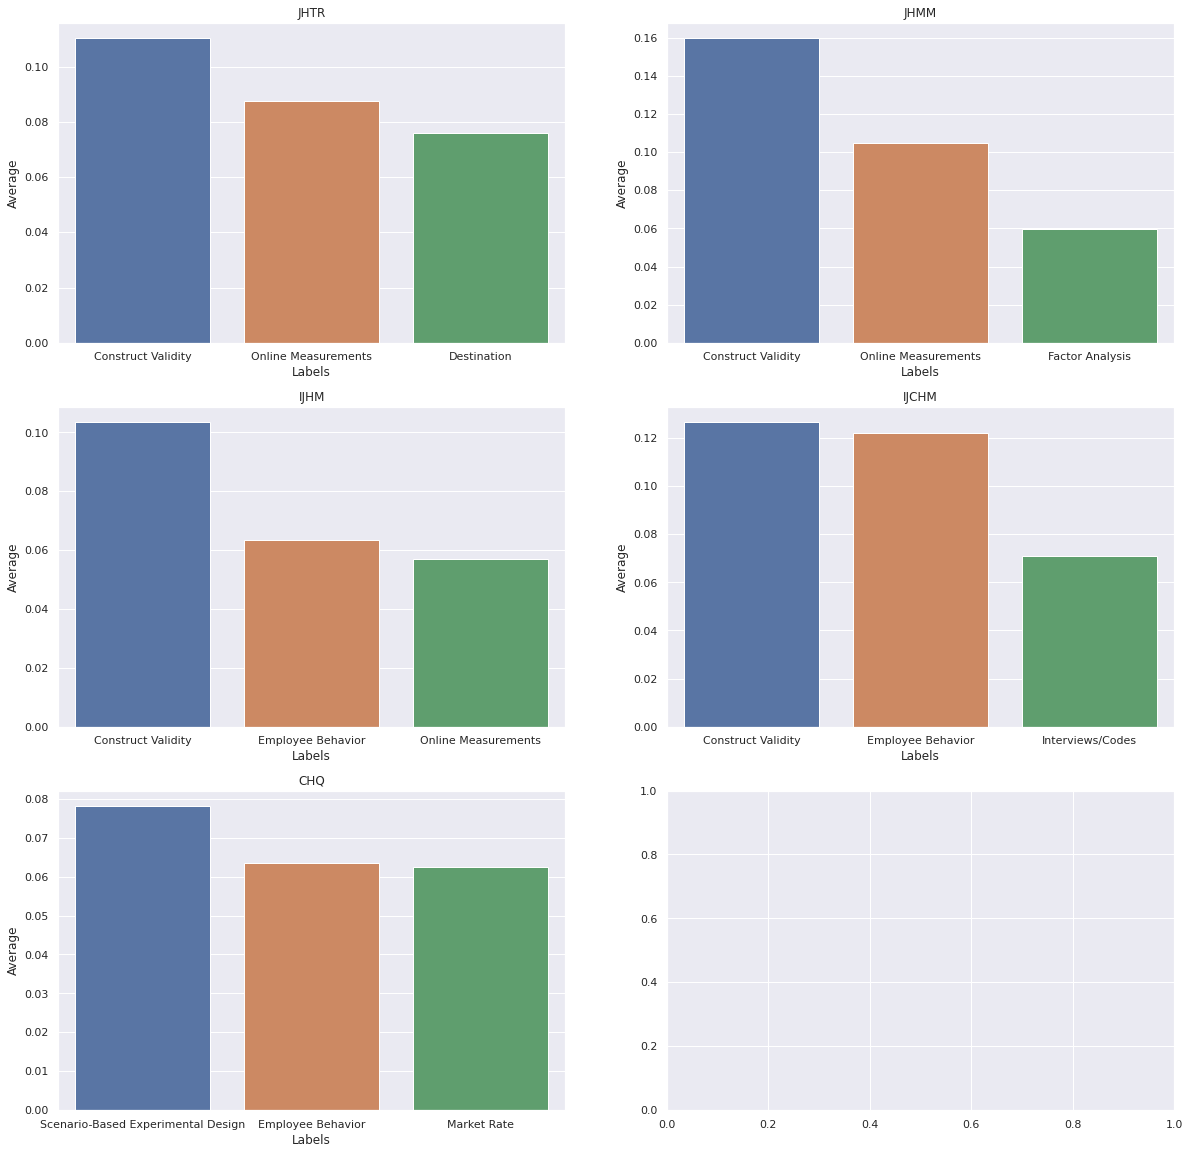

In [118]:
sns.set(font_scale=1)

plt.rcParams['figure.figsize'] = [20, 20]

plt.figure(figsize=(30,20))
fig, ax =plt.subplots(3,2)
for ax,j in zip(ax.flat, df_largest["Journal"].unique()):
  
  df_temp= df_largest[df_largest["Journal"]==j]
  sns.barplot(data=df_temp, x='Labels', y="Average", ax=ax)
  ax.set_title(j)

In [119]:
df_highest

,Topic,Average,Journal,rank
0,Topic 1,0.078187,CHQ,1.0
1,Topic 2,0.000000,CHQ,29.0
2,Topic 3,0.000000,CHQ,12.0
3,Topic 4,0.000000,CHQ,13.0
4,Topic 5,0.000000,CHQ,20.0
...,...,...,...,...
25,Topic 26,0.000000,JHTR,4.0
26,Topic 27,0.110272,JHTR,1.0
27,Topic 28,0.000000,JHTR,30.0
28,Topic 29,0.000000,JHTR,17.0


In [120]:
df_method =pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/df_method.pkl")
df_method

,JO,AU,TI,PY,DI,QUANTITATIVE,Method,category,CMB,CMV,MB,MV,MSD,MR,SR,SED,MED,TSM,TLD,PSM,MSM,A,C,CBQO,DBQ,UEB,HSF,PSD,MV.1,GFS,DMLMF,SULMF
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room needs,2019.0,10.1108/IJCHM-01-2019-0061,0,phenomenology,CMB-free,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty,2019.0,10.1108/IJCHM-01-2019-0090,1,secondary data,CMB-free,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online ratings on hotel room rates,2019.0,10.1108/IJCHM-10-2018-0835,0,review,CMB-free,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimum wage implementation,2019.0,10.1108/IJCHM-10-2018-0827,1,survey,CMB-risk,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restaurant reviews: does distance matter?,2019.0,10.1108/IJCHM-03-2018-0235,1,experimental,CMB-free,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,JHMM,"de Leaniz, PMG; Rodriguez, IRD",Exploring the Antecedents of Hotel Customer Loyalty: A Social Identity Perspective,2015.0,10.1080/19368623.2014.891961,1,survey,CMB-risk,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3265,JHMM,"Prayag, G; Khoo-Lattimore, C; Sitruk, J","Casual Dining on the French Riviera: Examining the Relationship Between Visitors' Perceived Quality, Positive Emotions, and Behavioral Intentions",2015.0,10.1080/19368623.2014.859114,1,survey,CMB-risk,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3266,JHMM,"Morosan, C",The Influence of DMO Advertising on Specific Destination Visitation Behaviors,2015.0,10.1080/19368623.2014.891962,1,survey,CMB-risk,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3267,JHMM,"Memarzadeh, F; Chang, HJ",Online Consumer Complaints About Southeast Asian Luxury Hotels,2015.0,10.1080/19368623.2014.893222,0,content analysis,CMB-free,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
df_corp = corpus_topic_df_lables.copy()

In [122]:
df_corp

,Document,Dominant Topic,Labels,Contribution %,Topic Desc,Title
0,0,20,Case Studies,36.62,"case, approach, process, stage, design, context, researcher, source, system, understand",Towards a hierarchy of hotel guests' in-room needs
1,1,22,Room Rate,32.94,"room, price, guest, rate, property, host, stay, airbnb, average, location",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty
2,2,18,Regression Analysis,34.70,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue",A meta-regression on the effect of online ratings on hotel room rates
3,3,29,Hospitality,31.73,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",Examining work factors after Malaysia's minimum wage implementation
4,4,1,Scenario-Based Experimental Design,32.88,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Seeking reward or avoiding risk from restaurant reviews: does distance matter?
...,...,...,...,...,...,...
3071,3071,21,Service Quality,25.72,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",The Effect Of Geographic Dispersion On The Initial And Long-Run IPO Performance
3072,3072,21,Service Quality,33.77,"service, customer, quality, experience, satisfaction, emotion, guest, feel, dimension, positive",Temporal Analysis of Tourism Research Collaboration Network
3073,3073,29,Hospitality,37.42,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",The Development of Quality Standards for Rural Farm Accommodations: A Case Study in South Korea
3074,3074,1,Scenario-Based Experimental Design,43.38,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Understanding Chinese Overseas Recreational Vehicle Tourists: A Netnographic and Comparative Approach


In [123]:
df_corp["DI"] = df["DI"]

In [124]:
df_corp.isnull().sum()

Document            0
Dominant Topic      0
Labels              0
Contribution %      0
Topic Desc          0
Title             186
DI                  1
dtype: int64

In [125]:
df_corp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Document        3076 non-null   int64  
 1   Dominant Topic  3076 non-null   int64  
 2   Labels          3076 non-null   object 
 3   Contribution %  3076 non-null   float64
 4   Topic Desc      3076 non-null   object 
 5   Title           2890 non-null   object 
 6   DI              3075 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 168.3+ KB


In [126]:
df_mm = pd.merge(df_method[["JO", "AU", "TI", "PY", "DI", "QUANTITATIVE", "Method"]], df_corp, left_on="DI", right_on="DI")
df_mm

,JO,AU,TI,PY,DI,QUANTITATIVE,Method,Document,Dominant Topic,Labels,Contribution %,Topic Desc,Title
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room needs,2019.0,10.1108/IJCHM-01-2019-0061,0,phenomenology,0,20,Case Studies,36.62,"case, approach, process, stage, design, context, researcher, source, system, understand",Towards a hierarchy of hotel guests' in-room needs
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty,2019.0,10.1108/IJCHM-01-2019-0090,1,secondary data,1,22,Room Rate,32.94,"room, price, guest, rate, property, host, stay, airbnb, average, location",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online ratings on hotel room rates,2019.0,10.1108/IJCHM-10-2018-0835,0,review,2,18,Regression Analysis,34.70,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue",A meta-regression on the effect of online ratings on hotel room rates
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimum wage implementation,2019.0,10.1108/IJCHM-10-2018-0827,1,survey,3,29,Hospitality,31.73,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",Examining work factors after Malaysia's minimum wage implementation
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restaurant reviews: does distance matter?,2019.0,10.1108/IJCHM-03-2018-0235,1,experimental,4,1,Scenario-Based Experimental Design,32.88,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Seeking reward or avoiding risk from restaurant reviews: does distance matter?
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,JHMM,"Ong, BS","Attitudes, Perceptions, and Responses of Purchasers Versus Subscribers-Only for Daily Deals on Hospitality Products",2015.0,10.1080/19368623.2014.901201,1,survey,2755,8,Wine Marketing,33.47,"wine, price, consumer, purchase, discount, choice, product, winery, group, quality",Determinants of dining satisfaction
3074,JHMM,"de Leaniz, PMG; Rodriguez, IRD",Exploring the Antecedents of Hotel Customer Loyalty: A Social Identity Perspective,2015.0,10.1080/19368623.2014.891961,1,survey,2756,27,Construct Validity,74.29,"construct, measurement, validity, researcher, section, participant, pilot, reliability, complete, adopt","Effect of job insecurity, anxiety and personal resources on job satisfaction among casino employees in macau: a moderated mediation analysis"
3075,JHMM,"Prayag, G; Khoo-Lattimore, C; Sitruk, J","Casual Dining on the French Riviera: Examining the Relationship Between Visitors' Perceived Quality, Positive Emotions, and Behavioral Intentions",2015.0,10.1080/19368623.2014.859114,1,survey,2757,9,Destination,49.49,"tourist, tourism, destination, country, travel, visitor, international, city, local, group",Humanlike robots as employees in the hotel industry: Thematic content analysis of online reviews
3076,JHMM,"Morosan, C",The Influence of DMO Advertising on Specific Destination Visitation Behaviors,2015.0,10.1080/19368623.2014.891962,1,survey,2758,11,Online Measurements,57.18,"online, participant, experience, travel, perceive, stay, demographic, adapt, measurement, intention",Social media engagement and organic post effectiveness: A roadmap for increasing the effectiveness of social media use in hospitality industry


In [127]:
df_mm.drop_duplicates(subset="TI", inplace=True, ignore_index=True)

In [128]:
df_mm

,JO,AU,TI,PY,DI,QUANTITATIVE,Method,Document,Dominant Topic,Labels,Contribution %,Topic Desc,Title
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room needs,2019.0,10.1108/IJCHM-01-2019-0061,0,phenomenology,0,20,Case Studies,36.62,"case, approach, process, stage, design, context, researcher, source, system, understand",Towards a hierarchy of hotel guests' in-room needs
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty,2019.0,10.1108/IJCHM-01-2019-0090,1,secondary data,1,22,Room Rate,32.94,"room, price, guest, rate, property, host, stay, airbnb, average, location",Barcelona's peer-to-peer tourist accommodation market in turbulent times Terrorism and political uncertainty
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online ratings on hotel room rates,2019.0,10.1108/IJCHM-10-2018-0835,0,review,2,18,Regression Analysis,34.70,"estimate, input, efficiency, output, function, demand, equation, regression, coefficient, revenue",A meta-regression on the effect of online ratings on hotel room rates
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimum wage implementation,2019.0,10.1108/IJCHM-10-2018-0827,1,survey,3,29,Hospitality,31.73,"work, employee, hospitality, industry, career, participant, student, feel, satisfaction, organization",Examining work factors after Malaysia's minimum wage implementation
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restaurant reviews: does distance matter?,2019.0,10.1108/IJCHM-03-2018-0235,1,experimental,4,1,Scenario-Based Experimental Design,32.88,"participant, scenario, condition, subject, experiment, design, manipulation, manipulate, group, perceive",Seeking reward or avoiding risk from restaurant reviews: does distance matter?
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,JHMM,"Ong, BS","Attitudes, Perceptions, and Responses of Purchasers Versus Subscribers-Only for Daily Deals on Hospitality Products",2015.0,10.1080/19368623.2014.901201,1,survey,2755,8,Wine Marketing,33.47,"wine, price, consumer, purchase, discount, choice, product, winery, group, quality",Determinants of dining satisfaction
3072,JHMM,"de Leaniz, PMG; Rodriguez, IRD",Exploring the Antecedents of Hotel Customer Loyalty: A Social Identity Perspective,2015.0,10.1080/19368623.2014.891961,1,survey,2756,27,Construct Validity,74.29,"construct, measurement, validity, researcher, section, participant, pilot, reliability, complete, adopt","Effect of job insecurity, anxiety and personal resources on job satisfaction among casino employees in macau: a moderated mediation analysis"
3073,JHMM,"Prayag, G; Khoo-Lattimore, C; Sitruk, J","Casual Dining on the French Riviera: Examining the Relationship Between Visitors' Perceived Quality, Positive Emotions, and Behavioral Intentions",2015.0,10.1080/19368623.2014.859114,1,survey,2757,9,Destination,49.49,"tourist, tourism, destination, country, travel, visitor, international, city, local, group",Humanlike robots as employees in the hotel industry: Thematic content analysis of online reviews
3074,JHMM,"Morosan, C",The Influence of DMO Advertising on Specific Destination Visitation Behaviors,2015.0,10.1080/19368623.2014.891962,1,survey,2758,11,Online Measurements,57.18,"online, participant, experience, travel, perceive, stay, demographic, adapt, measurement, intention",Social media engagement and organic post effectiveness: A roadmap for increasing the effectiveness of social media use in hospitality industry


In [129]:
m_list = ["Interviews/Codes",
"Construct Validity",
"Factor Analysis",
"Scenario-Based Experimental Design",
"Online Measurements",
"Regression Analysis",
"Case Studies",
"Article Reviews",
"Network Analysis",
"Demographics (Scale/Questionnaire)",
"Online Textual Analysis",
"Hypothesis Testing",
"Cluster Performance"]

In [130]:
df_mm.Method.value_counts()

survey               1511
secondary data        525
experimental          346
qualitative           177
mixed                 112
content analysis      104
case study             99
review                 76
scale development      38
bibliometric           18
grounded theory        16
phenomenology          15
theoretical            11
meta-analysis           7
ethnography             6
sna                     5
textual analysis        4
delphi                  3
interview               1
research note           1
field study             1
Name: Method, dtype: int64

In [131]:
for i in m_list:
  print("Method Types for " + i)
  print(df_mm.loc[df_mm.Labels==i, "Method"].value_counts())
  print()

Method Types for Interviews/Codes
qualitative          120
case study            26
content analysis      18
mixed                 18
grounded theory       11
phenomenology          8
survey                 7
review                 4
scale development      3
ethnography            3
research note          1
experimental           1
theoretical            1
interview              1
secondary data         1
Name: Method, dtype: int64

Method Types for Construct Validity
survey               376
scale development     13
mixed                  8
experimental           8
qualitative            4
secondary data         2
case study             1
phenomenology          1
Name: Method, dtype: int64

Method Types for Factor Analysis
survey               143
scale development     13
mixed                  5
experimental           2
secondary data         2
content analysis       1
Name: Method, dtype: int64

Method Types for Scenario-Based Experimental Design
experimental      163
survey        

In [132]:
# df_mm[df_mm.Labels=="Construct Validity"]["Method"].value_counts()

In [133]:
df_e

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Year,Journal
0,0.000032,0.000670,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.001308,0.001308,0.137193,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.366220,0.000032,0.083604,0.324753,0.000032,0.000032,0.000032,0.001308,0.000032,0.082967,0.000032,2019,IJCHM
1,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.104940,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.170336,0.000024,0.086591,0.000024,0.080946,0.000024,0.329358,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.227264,2019,IJCHM
2,0.000011,0.000011,0.000011,0.092573,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.095959,0.081285,0.000011,0.150818,0.000011,0.347003,0.000011,0.000011,0.000011,0.198905,0.032746,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000463,2019,IJCHM
3,0.000023,0.000023,0.000023,0.070887,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.067276,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.305146,0.238795,0.000023,0.317332,0.000023,2019,IJCHM
4,0.328791,0.000024,0.001466,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.228815,0.000024,0.110574,0.000024,0.268229,0.061548,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,2019,IJCHM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,0.000024,0.000024,0.000024,0.000024,0.000024,0.217343,0.000024,0.000024,0.000024,0.000024,0.225409,0.191246,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000498,0.000498,0.257200,0.000024,0.000024,0.000498,0.000024,0.092550,0.014259,0.000024,0.000024,0.000024,2010,JHTR
3072,0.000013,0.000013,0.000013,0.000013,0.000013,0.318320,0.000013,0.000013,0.000013,0.000013,0.000013,0.056723,0.000274,0.000013,0.000013,0.008898,0.008898,0.000013,0.000013,0.047837,0.337658,0.000013,0.000013,0.000013,0.011250,0.068222,0.141657,0.000013,0.000013,0.000013,2010,JHTR
3073,0.000005,0.000005,0.000005,0.132611,0.000733,0.000109,0.000005,0.020478,0.000005,0.097901,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.097797,0.000005,0.000005,0.000005,0.000005,0.000005,0.146745,0.129286,0.000005,0.374232,0.000005,2010,JHTR
3074,0.433759,0.004748,0.000024,0.000024,0.000024,0.000024,0.003803,0.000024,0.038767,0.000496,0.000024,0.072313,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.107276,0.140350,0.000024,0.002858,0.000024,0.000024,0.000024,0.195157,0.000024,0.000024,0.000024,2010,JHTR


In [134]:
df_e.drop(["Year", "Journal"], axis=1, inplace=True)

In [135]:
df_5 = pd.DataFrame(df_e.columns.values[np.argsort(-df_e.values, axis=1)[:, :5]], 
                  index=df_e.index,
                  columns = ['1st Topic','2nd Topic','3rd Topic', '4th Topic', '5th Topic'])
df_5

,1st Topic,2nd Topic,3rd Topic,4th Topic,5th Topic
0,Topic 20,Topic 23,Topic 11,Topic 22,Topic 29
1,Topic 22,Topic 30,Topic 16,Topic 9,Topic 18
2,Topic 18,Topic 22,Topic 16,Topic 13,Topic 4
3,Topic 29,Topic 26,Topic 27,Topic 4,Topic 11
4,Topic 1,Topic 16,Topic 12,Topic 14,Topic 17
...,...,...,...,...,...
3071,Topic 21,Topic 11,Topic 6,Topic 12,Topic 26
3072,Topic 21,Topic 6,Topic 27,Topic 26,Topic 12
3073,Topic 29,Topic 26,Topic 4,Topic 27,Topic 10
3074,Topic 1,Topic 27,Topic 21,Topic 20,Topic 12


In [136]:
labels

,Dominant Topic,Labels
0,1,Scenario-Based Experimental Design
1,2,Network Analysis
2,3,Service Management
3,4,Hypothesis Testing
4,5,Cluster Performance
5,6,Employee Behavior
6,7,Firm Performance
7,8,Wine Marketing
8,9,Destination
9,10,Cost Management


In [137]:
labels["Dominant Topic"] = "Topic " + labels["Dominant Topic"].astype("str")

In [138]:
labels

,Dominant Topic,Labels
0,Topic 1,Scenario-Based Experimental Design
1,Topic 2,Network Analysis
2,Topic 3,Service Management
3,Topic 4,Hypothesis Testing
4,Topic 5,Cluster Performance
5,Topic 6,Employee Behavior
6,Topic 7,Firm Performance
7,Topic 8,Wine Marketing
8,Topic 9,Destination
9,Topic 10,Cost Management


In [139]:
topic_dict = {k:v for k,v in zip(labels["Dominant Topic"], labels.Labels)}
topic_dict

{'Topic 1': 'Scenario-Based Experimental Design',
 'Topic 10': 'Cost Management',
 'Topic 11': 'Online Measurements',
 'Topic 12': 'Restaurant Management',
 'Topic 13': 'Article Reviews',
 'Topic 14': 'Demographics (Scale/Questionnaire)',
 'Topic 15': 'Sustainability',
 'Topic 16': 'Online Textual Analysis',
 'Topic 17': 'Brand Management',
 'Topic 18': 'Regression Analysis',
 'Topic 19': 'Event Management',
 'Topic 2': 'Network Analysis',
 'Topic 20': 'Case Studies',
 'Topic 21': 'Service Quality',
 'Topic 22': 'Room Rate',
 'Topic 23': 'Interviews/Codes',
 'Topic 24': 'Managers',
 'Topic 25': 'Innovation Performance',
 'Topic 26': 'Factor Analysis',
 'Topic 27': 'Construct Validity',
 'Topic 28': 'Casino',
 'Topic 29': 'Hospitality',
 'Topic 3': 'Service Management',
 'Topic 30': 'Market Rate',
 'Topic 4': 'Hypothesis Testing',
 'Topic 5': 'Cluster Performance',
 'Topic 6': 'Employee Behavior',
 'Topic 7': 'Firm Performance',
 'Topic 8': 'Wine Marketing',
 'Topic 9': 'Destination'}

In [140]:
df_5 = df_5.replace(topic_dict)

In [141]:
df_5

,1st Topic,2nd Topic,3rd Topic,4th Topic,5th Topic
0,Case Studies,Interviews/Codes,Online Measurements,Room Rate,Hospitality
1,Room Rate,Market Rate,Online Textual Analysis,Destination,Regression Analysis
2,Regression Analysis,Room Rate,Online Textual Analysis,Article Reviews,Hypothesis Testing
3,Hospitality,Factor Analysis,Construct Validity,Hypothesis Testing,Online Measurements
4,Scenario-Based Experimental Design,Online Textual Analysis,Restaurant Management,Demographics (Scale/Questionnaire),Brand Management
...,...,...,...,...,...
3071,Service Quality,Online Measurements,Employee Behavior,Restaurant Management,Factor Analysis
3072,Service Quality,Employee Behavior,Construct Validity,Factor Analysis,Restaurant Management
3073,Hospitality,Factor Analysis,Hypothesis Testing,Construct Validity,Cost Management
3074,Scenario-Based Experimental Design,Construct Validity,Service Quality,Case Studies,Restaurant Management


In [142]:
df_5.columns

Index(['1st Topic', '2nd Topic', '3rd Topic', '4th Topic', '5th Topic'], dtype='object')

In [143]:
df_5["Top5"] = df_5['1st Topic'] + ", " + df_5['2nd Topic'] + ", " + df_5['3rd Topic'] + ", " + df_5['4th Topic'] + ", " + df_5['5th Topic']

In [144]:
df_5["Top3"] = df_5['1st Topic'] + ", " + df_5['2nd Topic'] + ", " + df_5['3rd Topic']

In [145]:
df_5["Method"] = df_mm["Method"]

In [146]:
df_5

,1st Topic,2nd Topic,3rd Topic,4th Topic,5th Topic,Top5,Top3,Method
0,Case Studies,Interviews/Codes,Online Measurements,Room Rate,Hospitality,"Case Studies, Interviews/Codes, Online Measurements, Room Rate, Hospitality","Case Studies, Interviews/Codes, Online Measurements",phenomenology
1,Room Rate,Market Rate,Online Textual Analysis,Destination,Regression Analysis,"Room Rate, Market Rate, Online Textual Analysis, Destination, Regression Analysis","Room Rate, Market Rate, Online Textual Analysis",secondary data
2,Regression Analysis,Room Rate,Online Textual Analysis,Article Reviews,Hypothesis Testing,"Regression Analysis, Room Rate, Online Textual Analysis, Article Reviews, Hypothesis Testing","Regression Analysis, Room Rate, Online Textual Analysis",review
3,Hospitality,Factor Analysis,Construct Validity,Hypothesis Testing,Online Measurements,"Hospitality, Factor Analysis, Construct Validity, Hypothesis Testing, Online Measurements","Hospitality, Factor Analysis, Construct Validity",survey
4,Scenario-Based Experimental Design,Online Textual Analysis,Restaurant Management,Demographics (Scale/Questionnaire),Brand Management,"Scenario-Based Experimental Design, Online Textual Analysis, Restaurant Management, Demographics (Scale/Questionnaire), Brand Management","Scenario-Based Experimental Design, Online Textual Analysis, Restaurant Management",experimental
...,...,...,...,...,...,...,...,...
3071,Service Quality,Online Measurements,Employee Behavior,Restaurant Management,Factor Analysis,"Service Quality, Online Measurements, Employee Behavior, Restaurant Management, Factor Analysis","Service Quality, Online Measurements, Employee Behavior",survey
3072,Service Quality,Employee Behavior,Construct Validity,Factor Analysis,Restaurant Management,"Service Quality, Employee Behavior, Construct Validity, Factor Analysis, Restaurant Management","Service Quality, Employee Behavior, Construct Validity",survey
3073,Hospitality,Factor Analysis,Hypothesis Testing,Construct Validity,Cost Management,"Hospitality, Factor Analysis, Hypothesis Testing, Construct Validity, Cost Management","Hospitality, Factor Analysis, Hypothesis Testing",survey
3074,Scenario-Based Experimental Design,Construct Validity,Service Quality,Case Studies,Restaurant Management,"Scenario-Based Experimental Design, Construct Validity, Service Quality, Case Studies, Restaurant Management","Scenario-Based Experimental Design, Construct Validity, Service Quality",survey


In [147]:
# df_mm.loc[df_5.Top5.str.contains("Construct Validity"), "Method"].value_counts()

In [148]:
for i in m_list:
  print("Method Types for " + i)
  print(df_5.loc[df_5.Top5.str.contains(i), "Method"].value_counts())
  print()

Method Types for Interviews/Codes
survey               160
qualitative          141
case study            59
mixed                 45
content analysis      41
secondary data        37
experimental          32
review                22
scale development     19
grounded theory       14
phenomenology         13
ethnography            4
delphi                 2
theoretical            2
interview              1
textual analysis       1
Name: Method, dtype: int64

Method Types for Construct Validity
survey               892
experimental         117
secondary data        92
mixed                 47
qualitative           35
scale development     26
content analysis      23
case study            20
review                20
bibliometric           5
phenomenology          3
theoretical            2
sna                    2
meta-analysis          2
delphi                 2
ethnography            2
grounded theory        2
research note          1
interview              1
textual analysis       1
Na

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [149]:
topic_dict

{'Topic 1': 'Scenario-Based Experimental Design',
 'Topic 10': 'Cost Management',
 'Topic 11': 'Online Measurements',
 'Topic 12': 'Restaurant Management',
 'Topic 13': 'Article Reviews',
 'Topic 14': 'Demographics (Scale/Questionnaire)',
 'Topic 15': 'Sustainability',
 'Topic 16': 'Online Textual Analysis',
 'Topic 17': 'Brand Management',
 'Topic 18': 'Regression Analysis',
 'Topic 19': 'Event Management',
 'Topic 2': 'Network Analysis',
 'Topic 20': 'Case Studies',
 'Topic 21': 'Service Quality',
 'Topic 22': 'Room Rate',
 'Topic 23': 'Interviews/Codes',
 'Topic 24': 'Managers',
 'Topic 25': 'Innovation Performance',
 'Topic 26': 'Factor Analysis',
 'Topic 27': 'Construct Validity',
 'Topic 28': 'Casino',
 'Topic 29': 'Hospitality',
 'Topic 3': 'Service Management',
 'Topic 30': 'Market Rate',
 'Topic 4': 'Hypothesis Testing',
 'Topic 5': 'Cluster Performance',
 'Topic 6': 'Employee Behavior',
 'Topic 7': 'Firm Performance',
 'Topic 8': 'Wine Marketing',
 'Topic 9': 'Destination'}

In [150]:
df_e

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,0.000032,0.000670,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.001308,0.001308,0.137193,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.366220,0.000032,0.083604,0.324753,0.000032,0.000032,0.000032,0.001308,0.000032,0.082967,0.000032
1,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.104940,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.170336,0.000024,0.086591,0.000024,0.080946,0.000024,0.329358,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.227264
2,0.000011,0.000011,0.000011,0.092573,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.095959,0.081285,0.000011,0.150818,0.000011,0.347003,0.000011,0.000011,0.000011,0.198905,0.032746,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000463
3,0.000023,0.000023,0.000023,0.070887,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.067276,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.305146,0.238795,0.000023,0.317332,0.000023
4,0.328791,0.000024,0.001466,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.228815,0.000024,0.110574,0.000024,0.268229,0.061548,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,0.000024,0.000024,0.000024,0.000024,0.000024,0.217343,0.000024,0.000024,0.000024,0.000024,0.225409,0.191246,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000498,0.000498,0.257200,0.000024,0.000024,0.000498,0.000024,0.092550,0.014259,0.000024,0.000024,0.000024
3072,0.000013,0.000013,0.000013,0.000013,0.000013,0.318320,0.000013,0.000013,0.000013,0.000013,0.000013,0.056723,0.000274,0.000013,0.000013,0.008898,0.008898,0.000013,0.000013,0.047837,0.337658,0.000013,0.000013,0.000013,0.011250,0.068222,0.141657,0.000013,0.000013,0.000013
3073,0.000005,0.000005,0.000005,0.132611,0.000733,0.000109,0.000005,0.020478,0.000005,0.097901,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.097797,0.000005,0.000005,0.000005,0.000005,0.000005,0.146745,0.129286,0.000005,0.374232,0.000005
3074,0.433759,0.004748,0.000024,0.000024,0.000024,0.000024,0.003803,0.000024,0.038767,0.000496,0.000024,0.072313,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.107276,0.140350,0.000024,0.002858,0.000024,0.000024,0.000024,0.195157,0.000024,0.000024,0.000024


In [214]:
df_f = df_e.applymap(lambda x : x if x>=0.2 else 0)
df_f

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.36622,0.000000,0.000000,0.324753,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.329358,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.227264
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.347003,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.305146,0.238795,0.0,0.317332,0.000000
4,0.328791,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.228815,0.0,0.0,0.0,0.268229,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,0.000000,0.0,0.0,0.0,0.000000,0.217343,0.0,0.0,0.000000,0.0,0.225409,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.257200,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3072,0.000000,0.0,0.0,0.0,0.000000,0.318320,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.337658,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3073,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.374232,0.000000
3074,0.433759,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [215]:
df_f = df_f.reset_index().rename(columns={"index":"AId"})
df_f

,AId,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.36622,0.000000,0.000000,0.324753,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.329358,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.227264
2,2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.347003,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.305146,0.238795,0.0,0.317332,0.000000
4,4,0.328791,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.228815,0.0,0.0,0.0,0.268229,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,3071,0.000000,0.0,0.0,0.0,0.000000,0.217343,0.0,0.0,0.000000,0.0,0.225409,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.257200,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3072,3072,0.000000,0.0,0.0,0.0,0.000000,0.318320,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.337658,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3073,3073,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.374232,0.000000
3074,3074,0.433759,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [216]:
df_f = df_f.melt(id_vars="AId")
df_f

,AId,variable,value
0,0,Topic 1,0.000000
1,1,Topic 1,0.000000
2,2,Topic 1,0.000000
3,3,Topic 1,0.000000
4,4,Topic 1,0.328791
...,...,...,...
92275,3071,Topic 30,0.000000
92276,3072,Topic 30,0.000000
92277,3073,Topic 30,0.000000
92278,3074,Topic 30,0.000000


In [217]:
df_f = df_f[df_f.value>0]
df_f

,AId,variable,value
4,4,Topic 1,0.328791
8,8,Topic 1,0.354096
35,35,Topic 1,0.252685
46,46,Topic 1,0.528370
71,71,Topic 1,0.256770
...,...,...,...
92152,2948,Topic 30,0.367862
92218,3014,Topic 30,0.883774
92221,3017,Topic 30,0.511892
92247,3043,Topic 30,0.347230


In [218]:
df_f["variable"] = df_f.variable.replace(topic_dict)
df_f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,AId,variable,value
4,4,Scenario-Based Experimental Design,0.328791
8,8,Scenario-Based Experimental Design,0.354096
35,35,Scenario-Based Experimental Design,0.252685
46,46,Scenario-Based Experimental Design,0.528370
71,71,Scenario-Based Experimental Design,0.256770
...,...,...,...
92152,2948,Market Rate,0.367862
92218,3014,Market Rate,0.883774
92221,3017,Market Rate,0.511892
92247,3043,Market Rate,0.347230


In [219]:
# df_g = df_f.pivot(index = "AId", columns="variable", values="value")
# df_g

In [220]:
df_g = pd.DataFrame(df_f.groupby("AId")["variable"].unique())
df_g

,variable
AId,
0,"[Case Studies, Interviews/Codes]"
1,"[Room Rate, Market Rate]"
2,[Regression Analysis]
3,"[Factor Analysis, Construct Validity, Hospitality]"
4,"[Scenario-Based Experimental Design, Restaurant Management, Online Textual Analysis]"
...,...
3071,"[Employee Behavior, Online Measurements, Service Quality]"
3072,"[Employee Behavior, Service Quality]"
3073,[Hospitality]


In [221]:
df_g["Method"] = df_mm["Method"]
df_g

,variable,Method
AId,,
0,"[Case Studies, Interviews/Codes]",phenomenology
1,"[Room Rate, Market Rate]",secondary data
2,[Regression Analysis],review
3,"[Factor Analysis, Construct Validity, Hospitality]",survey
4,"[Scenario-Based Experimental Design, Restaurant Management, Online Textual Analysis]",experimental
...,...,...
3071,"[Employee Behavior, Online Measurements, Service Quality]",survey
3072,"[Employee Behavior, Service Quality]",survey
3073,[Hospitality],survey


In [222]:
df_g.variable.apply(lambda x: "Case Studies" in x)

AId
0        True
1       False
2       False
3       False
4       False
        ...  
3071    False
3072    False
3073    False
3074    False
3075    False
Name: variable, Length: 3057, dtype: bool

In [223]:
for i in m_list:
  print("Method Types for " + i)
  mask = df_g.variable.apply(lambda x: i in x)
  print(df_g.loc[mask, "Method"].value_counts())
  print()

Method Types for Interviews/Codes
qualitative          124
case study            41
survey                38
content analysis      20
mixed                 20
phenomenology         13
review                12
grounded theory       12
scale development      9
experimental           9
secondary data         7
ethnography            3
delphi                 1
theoretical            1
interview              1
textual analysis       1
Name: Method, dtype: int64

Method Types for Construct Validity
survey               608
experimental          39
scale development     21
mixed                 20
secondary data        17
qualitative           10
case study             9
content analysis       7
review                 6
phenomenology          2
meta-analysis          1
bibliometric           1
theoretical            1
delphi                 1
ethnography            1
sna                    1
interview              1
Name: Method, dtype: int64

Method Types for Factor Analysis
survey          

In [259]:
df_x = df_g.variable.apply(pd.Series)

In [260]:
df_x

,0,1,2,3
AId,,,,
0,Case Studies,Interviews/Codes,NaN,NaN
1,Room Rate,Market Rate,NaN,NaN
2,Regression Analysis,NaN,NaN,NaN
3,Factor Analysis,Construct Validity,Hospitality,NaN
4,Scenario-Based Experimental Design,Restaurant Management,Online Textual Analysis,NaN
...,...,...,...,...
3071,Employee Behavior,Online Measurements,Service Quality,NaN
3072,Employee Behavior,Service Quality,NaN,NaN
3073,Hospitality,NaN,NaN,NaN


In [261]:
u_list=[]
for i in df_x.columns:
  u_list.extend(df_x[i].unique())


In [262]:
len(u_list)

91

In [263]:
u_list =list(set(u_list))

In [264]:
len(u_list)

31

In [265]:
u_list.remove(np.nan)

In [266]:
len(u_list)

30

In [267]:
df_x.fillna("", inplace=True)

In [268]:
df_x["a"] = df_x[0] + ", " + df_x[1] + ", " + df_x[2] + ", " + df_x[3]

In [269]:
df_x

,0,1,2,3,a
AId,,,,,
0,Case Studies,Interviews/Codes,,,"Case Studies, Interviews/Codes, ,"
1,Room Rate,Market Rate,,,"Room Rate, Market Rate, ,"
2,Regression Analysis,,,,"Regression Analysis, , ,"
3,Factor Analysis,Construct Validity,Hospitality,,"Factor Analysis, Construct Validity, Hospitality,"
4,Scenario-Based Experimental Design,Restaurant Management,Online Textual Analysis,,"Scenario-Based Experimental Design, Restaurant Management, Online Textual Analysis,"
...,...,...,...,...,...
3071,Employee Behavior,Online Measurements,Service Quality,,"Employee Behavior, Online Measurements, Service Quality,"
3072,Employee Behavior,Service Quality,,,"Employee Behavior, Service Quality, ,"
3073,Hospitality,,,,"Hospitality, , ,"


In [274]:
 df_x["a"] = df_x["a"].str.strip(", ,")

In [275]:
df_x

,0,1,2,3,a
AId,,,,,
0,Case Studies,Interviews/Codes,,,"Case Studies, Interviews/Codes"
1,Room Rate,Market Rate,,,"Room Rate, Market Rate"
2,Regression Analysis,,,,Regression Analysis
3,Factor Analysis,Construct Validity,Hospitality,,"Factor Analysis, Construct Validity, Hospitality"
4,Scenario-Based Experimental Design,Restaurant Management,Online Textual Analysis,,"Scenario-Based Experimental Design, Restaurant Management, Online Textual Analysis"
...,...,...,...,...,...
3071,Employee Behavior,Online Measurements,Service Quality,,"Employee Behavior, Online Measurements, Service Quality"
3072,Employee Behavior,Service Quality,,,"Employee Behavior, Service Quality"
3073,Hospitality,,,,Hospitality


In [277]:
df_x["a"].str.get_dummies(", ")

,Article Reviews,Brand Management,Case Studies,Casino,Cluster Performance,Construct Validity,Cost Management,Demographics (Scale/Questionnaire),Destination,Employee Behavior,Event Management,Factor Analysis,Firm Performance,Hospitality,Hypothesis Testing,Innovation Performance,Interviews/Codes,Managers,Market Rate,Network Analysis,Online Measurements,Online Textual Analysis,Regression Analysis,Restaurant Management,Room Rate,Scenario-Based Experimental Design,Service Management,Service Quality,Sustainability,Wine Marketing
AId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3072,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3073,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
